# Orion Tulog

This is a tutorial for anomaly detection using Orion. Orion is a `python` package for time series anoamly detection. It provides a suite of both statistical and machine learning models that enable efficient anomaly detection.

In this tutorial, we will learn how to set up Orion, train a machine learning model, and perform anomaly detection. We will delve into each part seperately and then run the evaluation pipeline from beginning to end in order to compare multiple models against each other.

In [1]:
# general imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

window_size = 100 #these hyperparameters will be defined after grid search
epoch = 10
learning_rate = 0.0005
latent_dim = 20
batch_size = 32
comb = "mult"
step_size = 100
drop_windows = False

## Part 1
In part one of the series, we explore a time series data, particularly the NYC taxi data. You can find the raw data on the [TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) or the processed version maintained by Numenta [here](https://github.com/numenta/NAB/tree/master/data). We also explore what reasons could possibily be contributing to producing such anomalies.

### Data Loading
There is a collection of data already available in Orion, to load them, we use the `load_signal` function and pass the name of the signal we wish to obtain. Similarly, since this data is labeled, we use the `load_anomalies` function to get the corresponding anomaly of the signal

In [2]:
from orion.data import load_signal, load_anomalies

In [3]:
df = pd.read_csv('swat.csv')

#df_train = df.iloc[:5*len(df.index)//8]
#df_test = df.iloc[:5*len(df.index)//8]
#df_test = df.iloc[:7500]
#df_train = df.iloc[7500:15000]
df = df.iloc[:37500]
df_test = df.iloc[:len(df.index)*2//10]
df_train = df.iloc[len(df.index)*2//10:]
df_train.head(5)

timestamp    FIT101    LIT101   MV101  P101  P102    AIT201  \
7500  1451304300000000000  2.590718  509.1475       2     2     1  263.4261   
7501  1451304301000000000  2.590718  509.1083       2     2     1  263.4261   
7502  1451304302000000000  2.590718  508.9513       2     2     1  263.4261   
7503  1451304303000000000  2.584953  508.6372       2     2     1  263.4261   
7504  1451304304000000000  2.583352  508.5195       2     2     1  263.4261   

        AIT202    AIT203    FIT201  ...  P501  P502    PIT501    PIT502  \
7500  8.368238  329.5309  2.444879  ...     2     1  249.6635  1.778105   
7501  8.366317  329.5309  2.443982  ...     2     1  249.6635  1.778105   
7502  8.366317  329.5309  2.441547  ...     2     1  249.6635  1.698010   
7503  8.366317  329.5309  2.439240  ...     2     1  249.6635  1.681991   
7504  8.366317  329.5309  2.439240  ...     2     1  249.6635  1.681991   

        PIT503    FIT601  P601  P602  P603  Normal/Attack  
7500  188.5254  1.737033     1     2     1         Normal  
7501  188.5734  1.737930     1     1     1         Normal  
7502  188.6375  1.738314     1     1     1         Normal  
7503  188.6375  1.734085     1     1     1         Normal  
7504  188.6375  1.677698     1     1     1         Normal  

[5 rows x 53 columns]

In [4]:
prev_state = "Normal"
anomalies = []
for ind in df_test.index:
    if prev_state == "Normal" and df_test['Normal/Attack'][ind] == "Attack":
        start = df_test['timestamp'][ind]
    if prev_state == "Attack" and df_test['Normal/Attack'][ind] == "Normal":
        stop = df_test['timestamp'][ind-1]
        anomalies.append([start, stop])
        
    prev_state = df_test['Normal/Attack'][ind]
    

known_anomalies = pd.DataFrame(anomalies, columns=['start', 'end'])

del df_train["Normal/Attack"]
del df_test["Normal/Attack"]

print(known_anomalies.shape)

(5, 2)


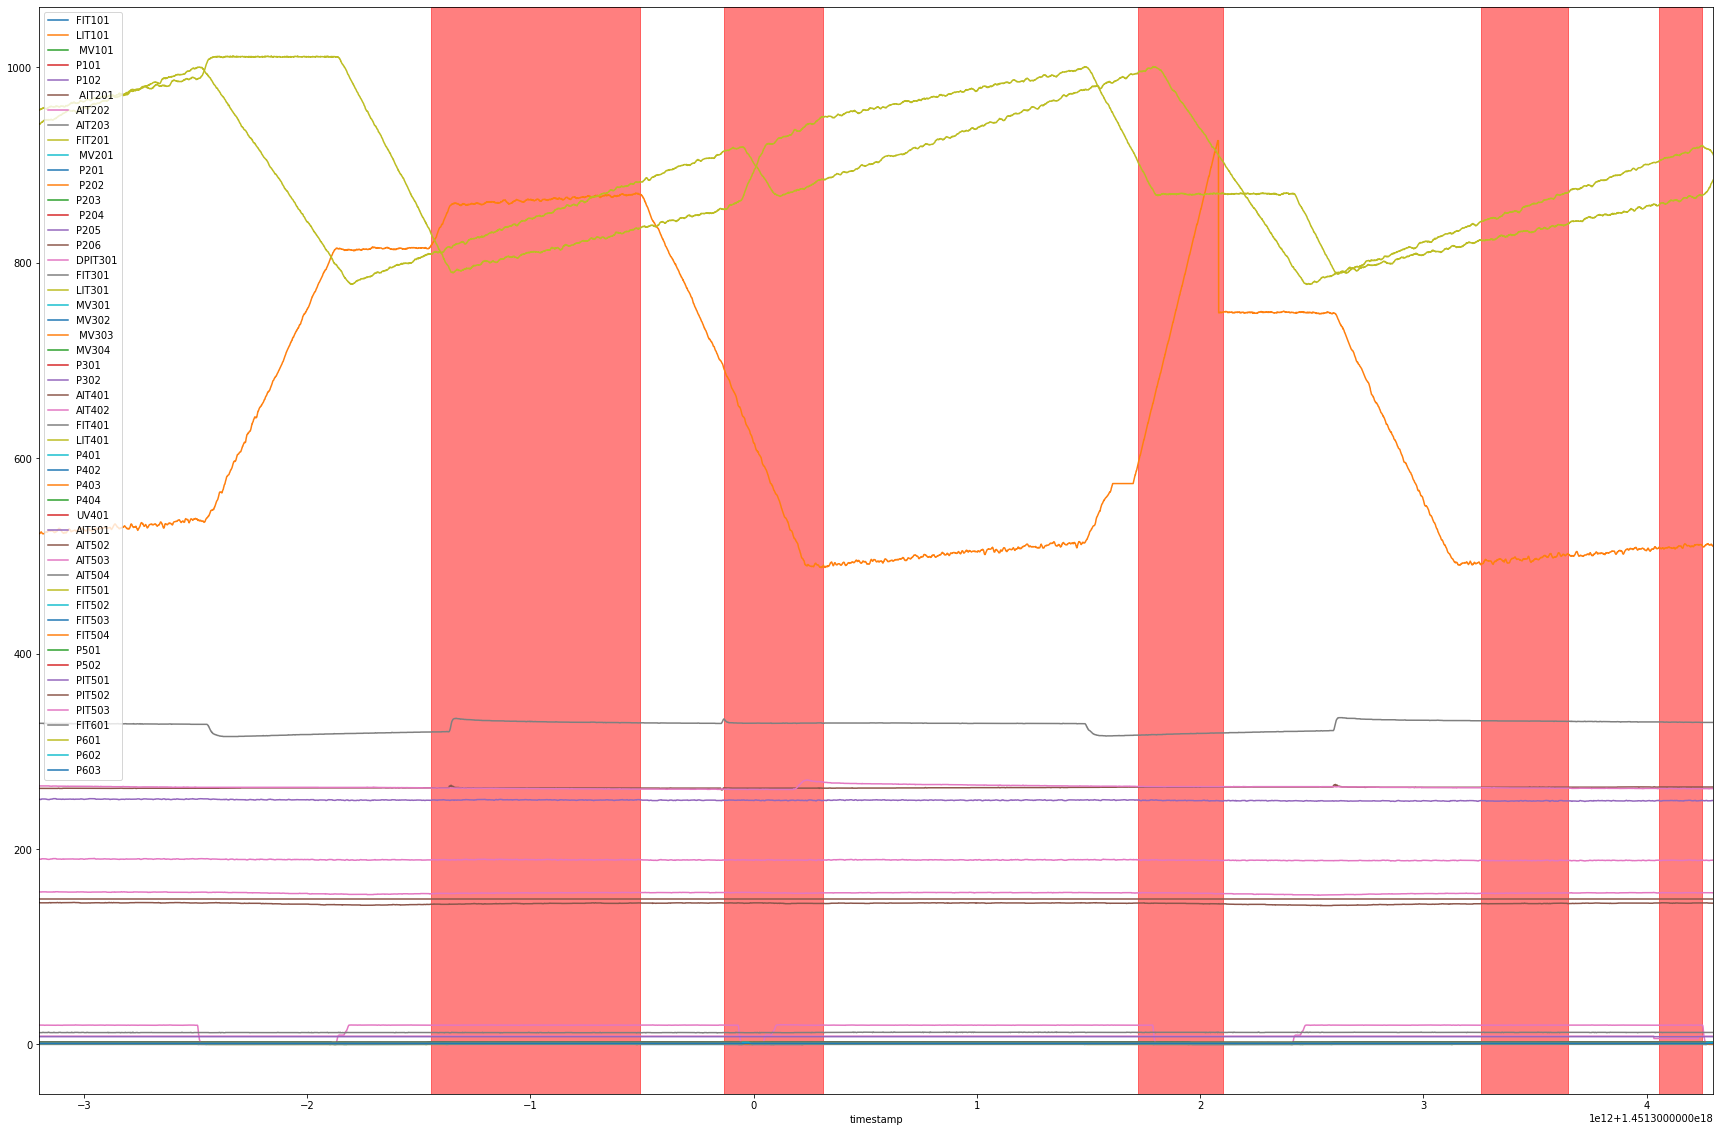

In [5]:
plt.rcParams['figure.figsize'] = [30, 20]
df_test.plot(x="timestamp")

for ind in range(len(known_anomalies)):
    plt.axvspan(known_anomalies["start"][ind], known_anomalies["end"][ind], color='red', alpha=0.5)

plt.show()

---

In [6]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X_tsa_train, index_train = time_segments_aggregate(df_train, interval=1000000000, time_column='timestamp')
X_tsa_test, index_test = time_segments_aggregate(df_test, interval=1000000000, time_column='timestamp')

In [7]:
# print(X_tsa_train.shape)
# print(X_tsa_train[:10,:1])
print(index_train.shape)
print(index_train[:10])

(30000,)
[1451304300000000000 1451304301000000000 1451304302000000000
 1451304303000000000 1451304304000000000 1451304305000000000
 1451304306000000000 1451304307000000000 1451304308000000000
 1451304309000000000]


#### B. data imputation

impute missing values that appear within the signal using scikit-learn's `SimpleImputer` which fills missing values by the mean value.

In [8]:
imp = SimpleImputer()
X_imp_train = imp.fit_transform(X_tsa_train)
X_imp_test = imp.fit_transform(X_tsa_test)

#### C. data normalization 
normalize the data between a specific range, we use scikit-learn's `MinMaxScaler` to scale data between [-1, 1].

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1)) ## for the gradients to converge faster == try 0-1 StandardScaler()
X_scl_train = scaler.fit_transform(X_imp_train)
X_scl_test = scaler.fit_transform(X_imp_test)

Notice how the y-axis changed after normalizing the data between [-1, 1]

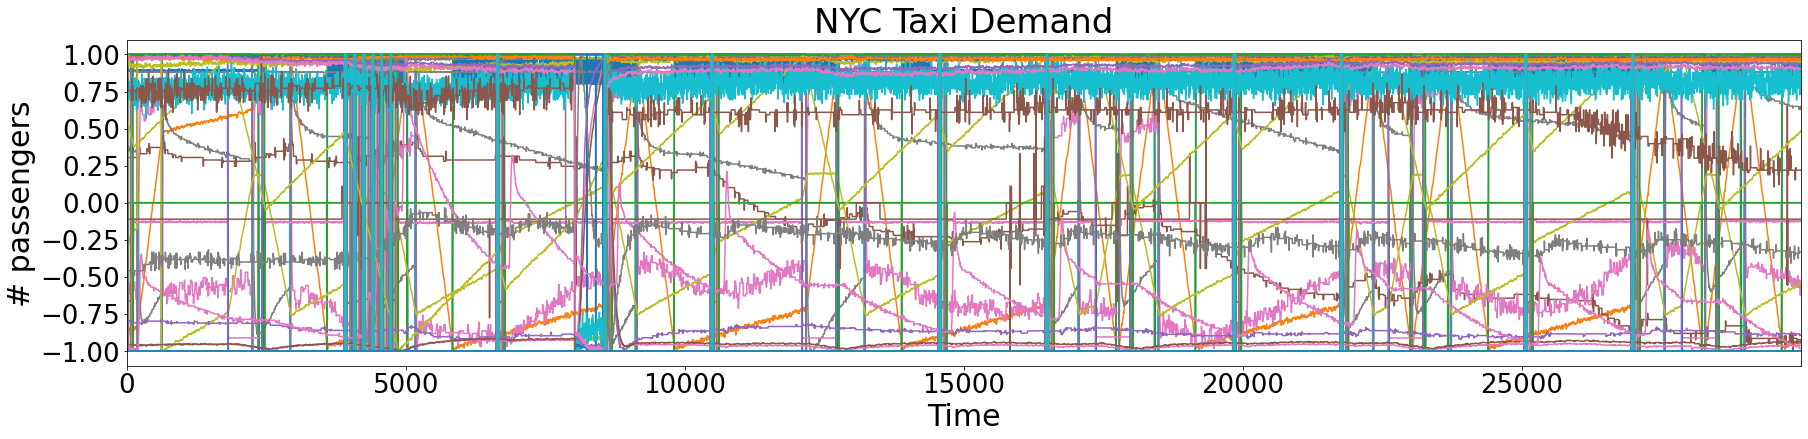

In [10]:
plot_ts(X_scl_train)

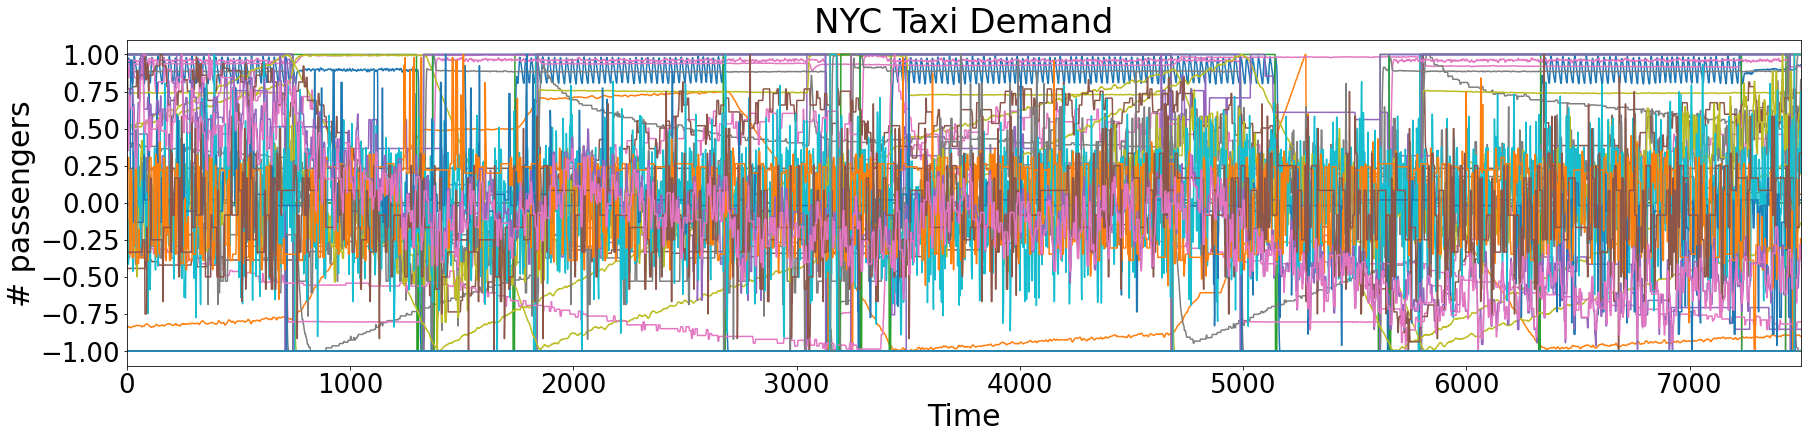

In [11]:
plot_ts(X_scl_test)

#### D. slice the data to rolling window
to prepare the data, we need to transform it into a sequence that is ingestable by the machine learning model. 
We take the signal we're interested in analyzing and we generate training examples. These training examples are mere snapshots of signal at different times.

In order to do that, we adopt the sliding window approach of choosing a window of a pre-specified width and a particular step size. Once that's been decided we divide the signal indo segments, similar to what is depicited in the illustration below.

<img src="images/sliding_window.png" alt="Drawing" style="width: 400px;"/>

We create a `rolling_window_sequence` function that slices the data into parts, each part contains:
- the target value; the value at time t.
- previous observed values, this is determined by the window width.

In [12]:
X_scl_test.shape[1]

51

In [13]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]
#     print("X.shape: ", X.shape)
#     print("target.shape: ", target.shape)

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X_rws_train, y_train, X_index_train, y_index_train = rolling_window_sequences(X_scl_train, index_train, 
                                                  window_size=window_size, 
                                                  target_size=X_scl_train.shape[1], 
                                                  step_size=step_size,
                                                  target_column=X_scl_train.shape[1]-1)

X_rws_test, y_test, X_index_test, y_index_test = rolling_window_sequences(X_scl_test, index_test, 
                                                  window_size=window_size, 
                                                  target_size=X_scl_test.shape[1], 
                                                  step_size=step_size,
                                                  target_column=X_scl_test.shape[1]-1)

In [14]:
print("Training data input shape: {}".format(X_rws_train.shape))
print("Training data index shape: {}".format(X_index_train.shape))
print("Training y shape: {}".format(y_train.shape))
print("Training y index shape: {}".format(y_index_train.shape))

Training data input shape: (299, 100, 51)
Training data index shape: (299,)
Training y shape: (299, 51)
Training y index shape: (299,)


In [15]:
print("Testing data input shape: {}".format(X_rws_test.shape))
print("Testing data index shape: {}".format(X_index_test.shape))
print("Testing y shape: {}".format(y_test.shape))
print("Testing y index shape: {}".format(y_index_test.shape))

Testing data input shape: (74, 100, 51)
Testing data index shape: (74,)
Testing y shape: (74, 51)
Testing y index shape: (74,)


In [ ]:
from model import hyperparameters
from tadgan import TadGAN
hyperparameters["epochs"] = epoch

print("X_rws_train.shape[2]", X_rws_train.shape[2])

hyperparameters["shape"] = (window_size, X_rws_train.shape[2]) # based on the window size
hyperparameters["critic_x_input_shape"] = (window_size, X_rws_train.shape[2])
hyperparameters["encoder_input_shape"] = (window_size, X_rws_train.shape[2])
hyperparameters["layers_generator"][1]["parameters"]["units"] = window_size//2
hyperparameters["generator_reshape_shape"] = (window_size//2, 1)
hyperparameters["layers_encoder"][0]["parameters"]["layer"]["parameters"]["units"] = window_size
hyperparameters["layers_critic_z"][1]["parameters"]["units"] = window_size
hyperparameters["layers_critic_z"][4]["parameters"]["units"] = window_size

hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = learning_rate

hyperparameters["latent_dim"] = latent_dim
hyperparameters["generator_input_shape"] = (latent_dim, 1)
hyperparameters["critic_z_input_shape"] = (latent_dim, 1)
hyperparameters["encoder_reshape_shape"] = (latent_dim, 1)
hyperparameters["layers_encoder"][2]["parameters"]["units"] = latent_dim

hyperparameters["batch_size"] = batch_size
hyperparameters["layers_generator"][3]["parameters"]["layer"]["parameters"]["units"] = batch_size
hyperparameters["layers_generator"][5]["parameters"]["layer"]["parameters"]["units"] = batch_size
hyperparameters["layers_critic_x"][0]["parameters"]["filters"] = batch_size
hyperparameters["layers_critic_x"][3]["parameters"]["filters"] = batch_size
hyperparameters["layers_critic_x"][6]["parameters"]["filters"] = batch_size
hyperparameters["layers_critic_x"][9]["parameters"]["filters"] = batch_size

hyperparameters["layers_generator"][6]["parameters"]["layer"]["parameters"]["units"] = X_rws_train.shape[2]
hyperparameters["layers_critic_x"][-1]["parameters"]["units"] = X_rws_train.shape[2]

tgan = TadGAN(**hyperparameters)
tgan.fit(X_rws_train)
#tgan.save_model(str(hyperparameters["epochs"]) + "_5/8")

Using TensorFlow backend.


X_rws_train.shape[2] 51
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/top/.pyenv/versions/3.7.12/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2021-12-28 12:16:25.136971: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


Text(0.5, 1.0, 'G')

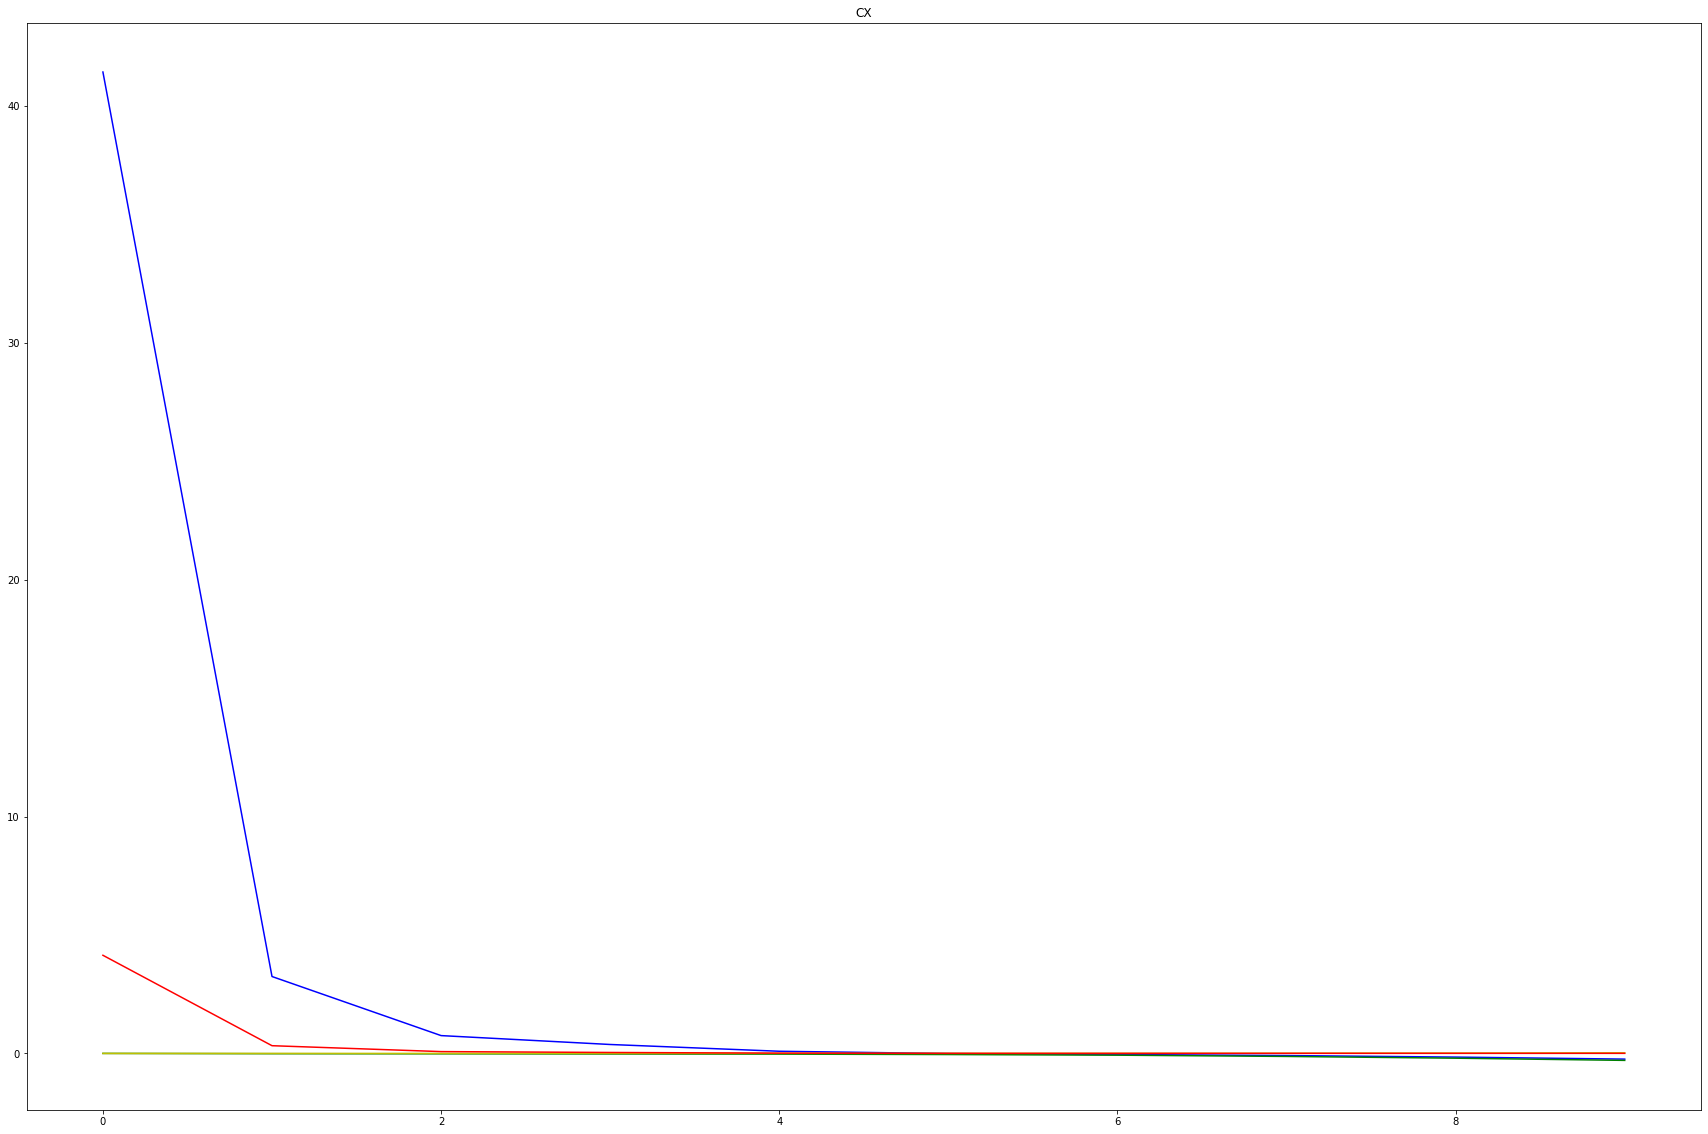

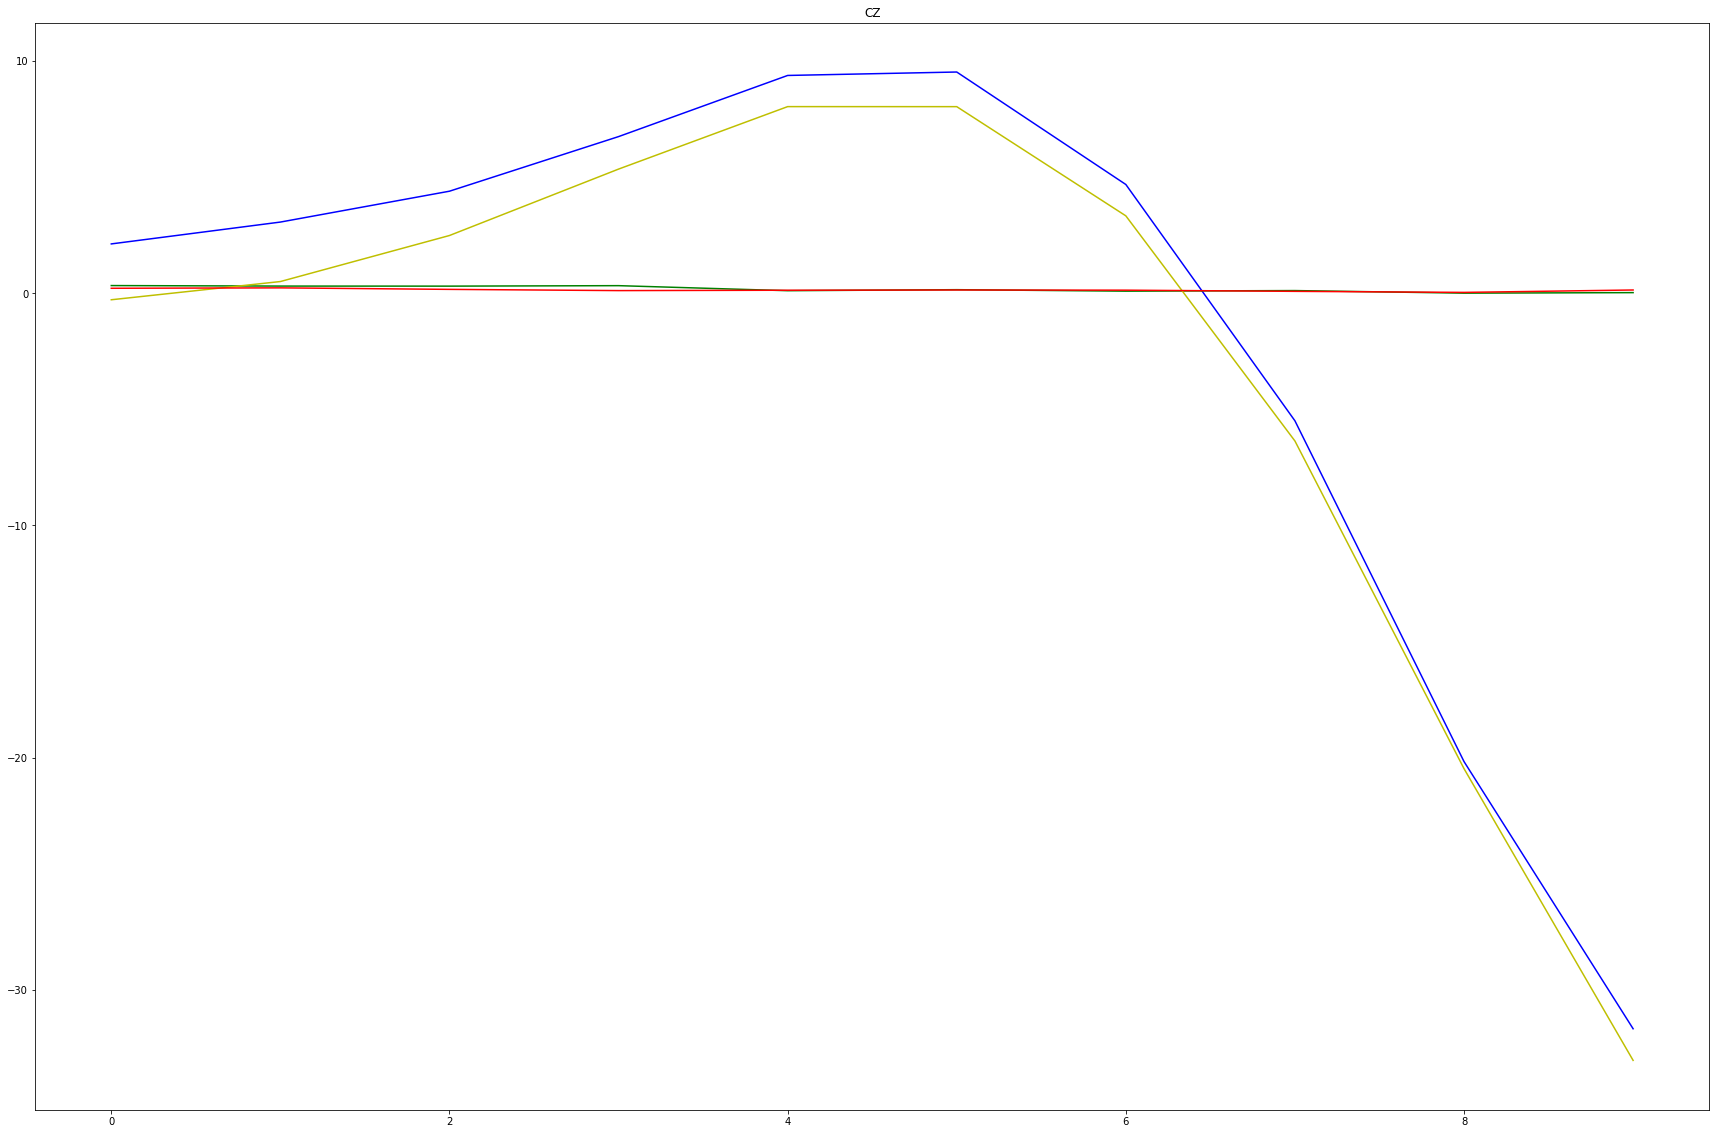

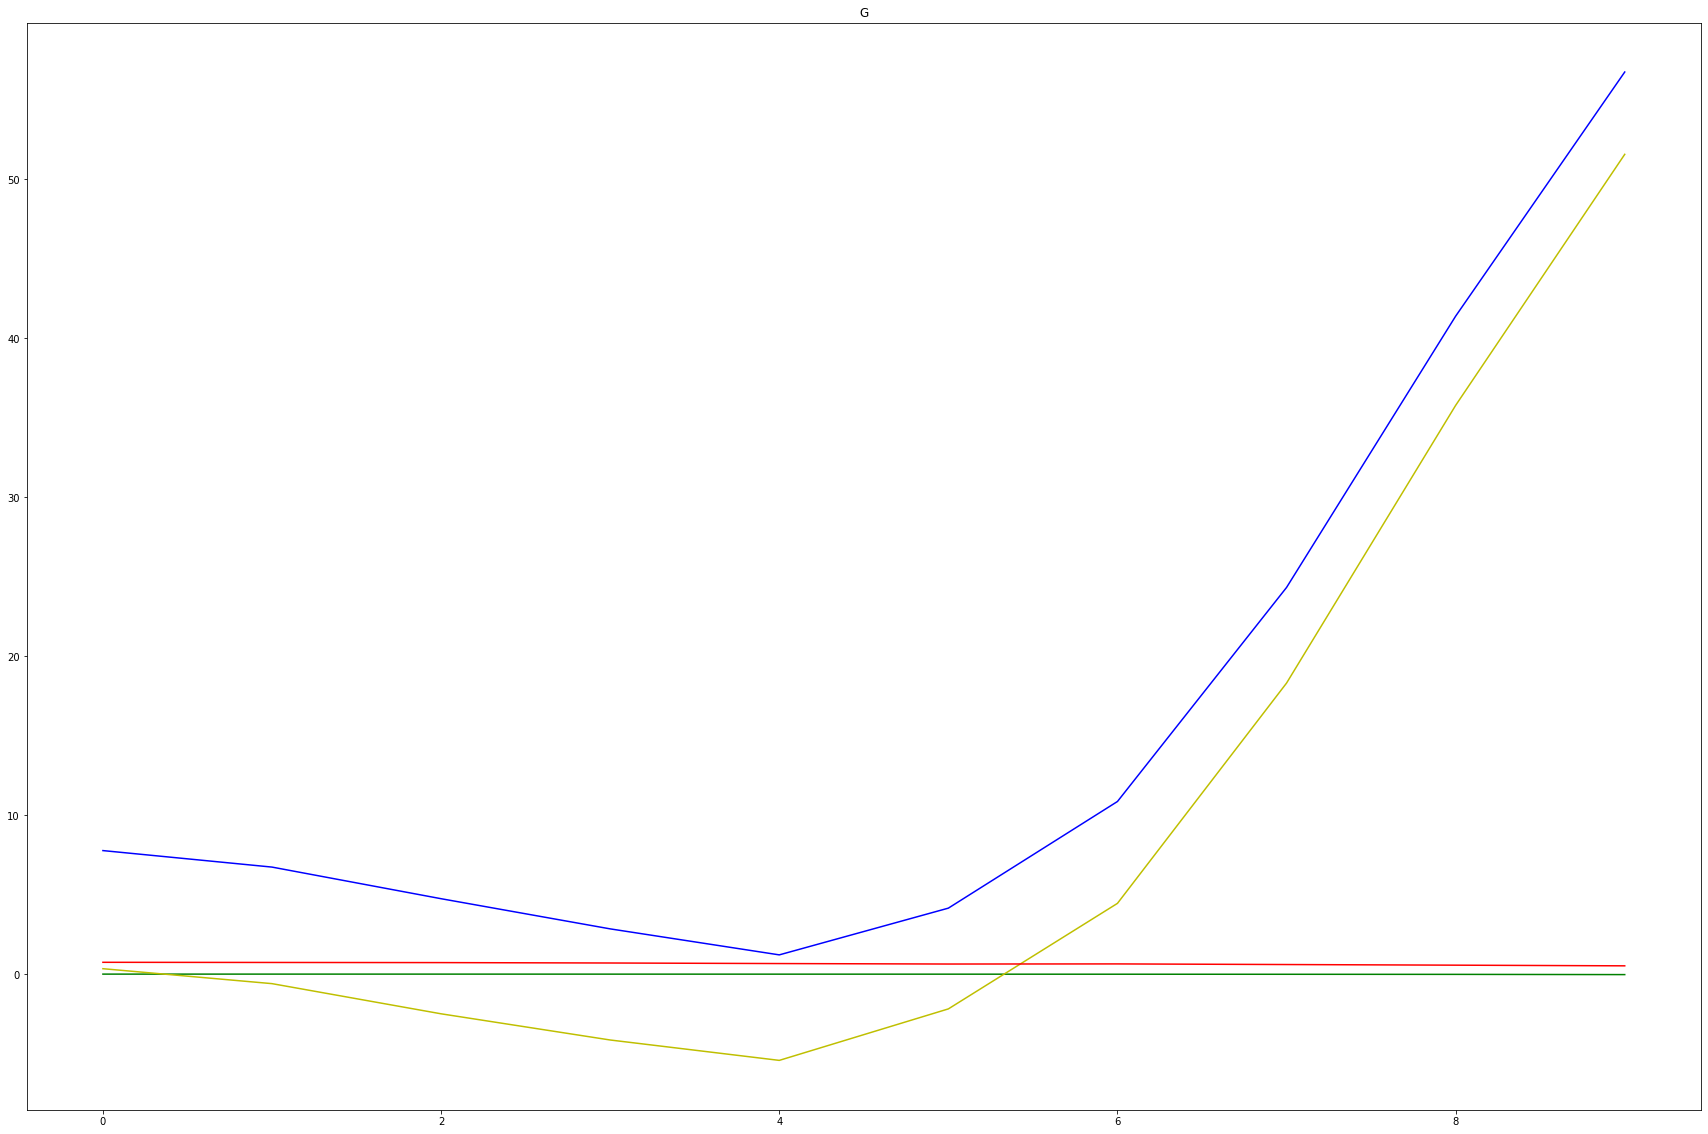

In [17]:
fig1, ax1 = plt.subplots()
ax1.plot(range(len(tgan.total_cx_loss)), np.array(tgan.total_cx_loss)[:,0], "-b")
ax1.plot(range(len(tgan.total_cx_loss)), np.array(tgan.total_cx_loss)[:,1], "-g")
ax1.plot(range(len(tgan.total_cx_loss)), np.array(tgan.total_cx_loss)[:,-2], "-y")
ax1.plot(range(len(tgan.total_cx_loss)), np.array(tgan.total_cx_loss)[:,-1], "-r")
ax1.set_title("CX")
#fig1.savefig('cx_10k_10epoch.png')

fig2, ax2 = plt.subplots()
ax2.plot(range(len(tgan.total_cz_loss)), np.array(tgan.total_cz_loss)[:,0], "-b")
ax2.plot(range(len(tgan.total_cz_loss)), np.array(tgan.total_cz_loss)[:,1], "-g")
ax2.plot(range(len(tgan.total_cz_loss)), np.array(tgan.total_cz_loss)[:,-2], "-y")
ax2.plot(range(len(tgan.total_cz_loss)), np.array(tgan.total_cz_loss)[:,-1], "-r")
ax2.set_title("CZ")
#fig2.savefig('cz_10k_10epoch.png')

fig3, ax3 = plt.subplots()
ax3.plot(range(len(tgan.total_g_loss)), np.array(tgan.total_g_loss)[:,0], "-b")
ax3.plot(range(len(tgan.total_g_loss)), np.array(tgan.total_g_loss)[:,1], "-g")
ax3.plot(range(len(tgan.total_g_loss)), np.array(tgan.total_g_loss)[:,-2], "-y")
ax3.plot(range(len(tgan.total_g_loss)), np.array(tgan.total_g_loss)[:,-1], "-r")
ax3.set_title("G")
#fig3.savefig('g_10k_10epoch.png')

In [18]:
# from tadgan import TadGAN
# tgan = TadGAN(**hyperparameters)
# tgan.load_model(str(hyperparameters["epochs"]))

In [19]:
# reconstruct
X_hat, critic = tgan.predict(X_rws_test)
print("X_hat.shape, critic.shape: ")
print(X_hat.shape, critic.shape)

X_hat.shape, critic.shape: 
(82, 100, 51) (82, 51)


In [20]:
y_hat = list()
for i in range(len(X_hat)):
    y_hat.append(X_hat[i][0])
    
y_hat = np.array(y_hat)

X_hat.shape, y_hat.shape, y_test.shape: 
(82, 100, 51) (82, 51) (82, 51)


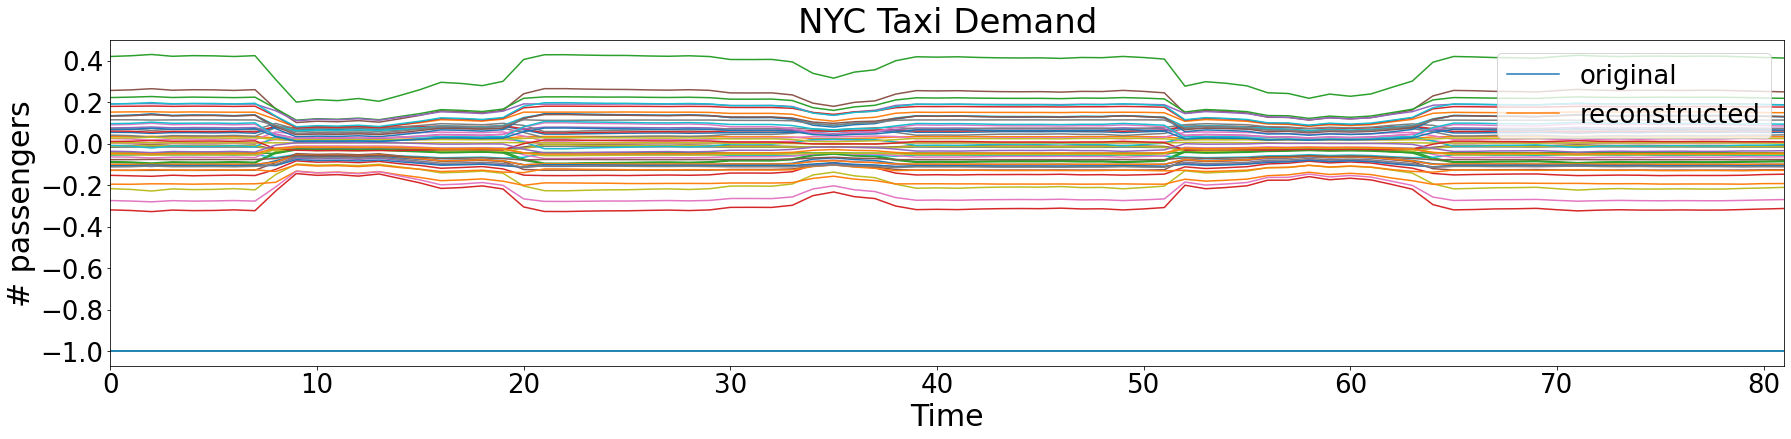

In [21]:
# flatten the predicted windows
print("X_hat.shape, y_hat.shape, y_test.shape: ")
print(X_hat.shape, y_hat.shape, y_test.shape)

# plot the time series
plot_ts([y_test, y_hat], labels=['original', 'reconstructed'])

In [22]:
from tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X_rws_test, X_hat, critic, X_index_test, rec_error_type="dtw", comb="mult")
print("error.shape, true_index.shape, true.shape, pred.shape")
print(np.array(error).shape, np.array(true_index).shape, np.array(true).shape, np.array(pred).shape)
pred = np.array(pred).mean(axis=2)

error.shape, true_index.shape, true.shape, pred.shape
(181,) (82,) (181, 51) (181, 1, 5, 51)


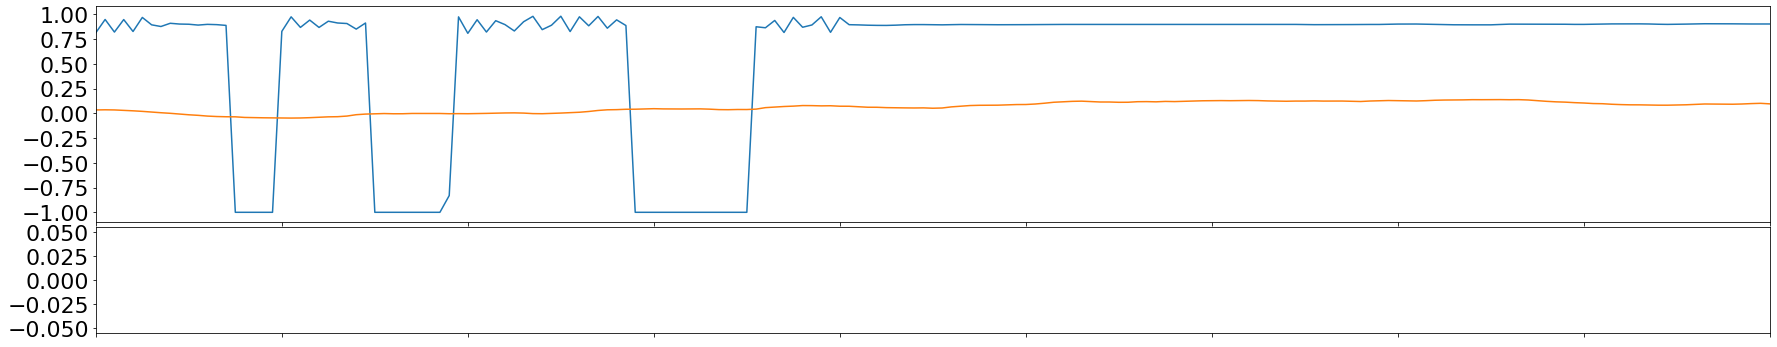

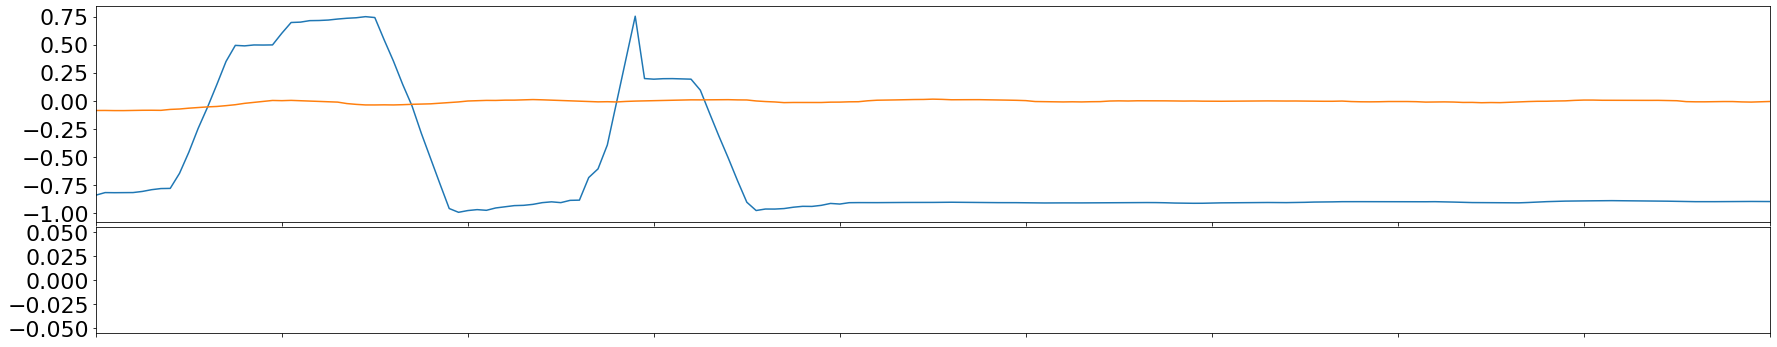

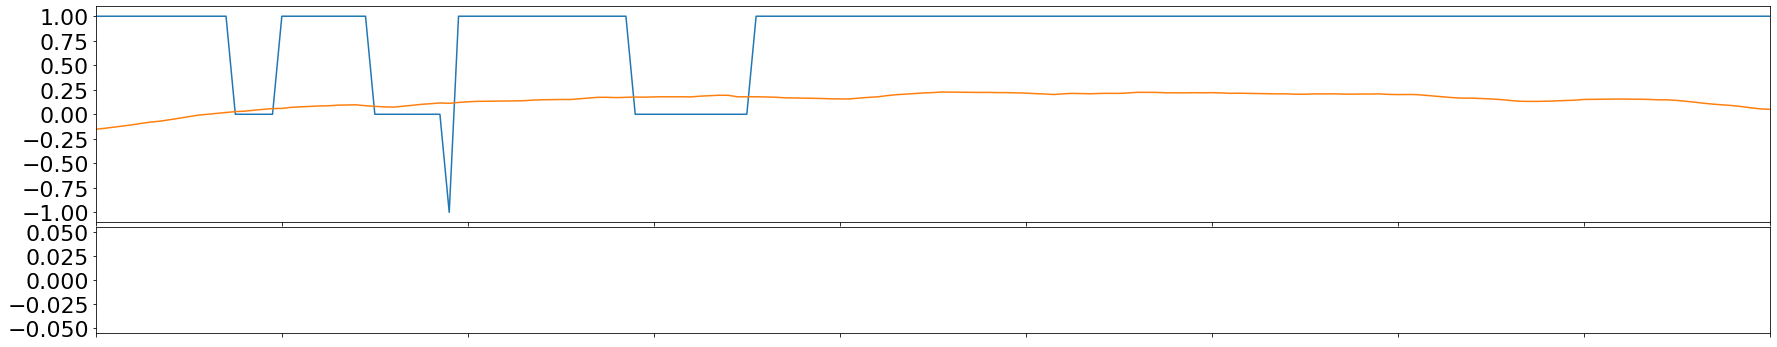

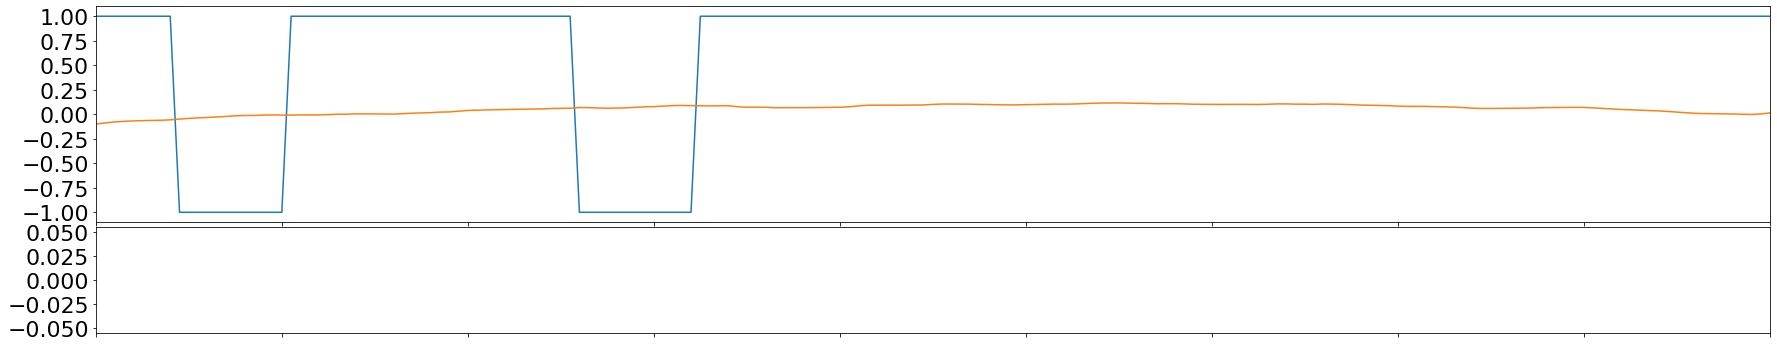

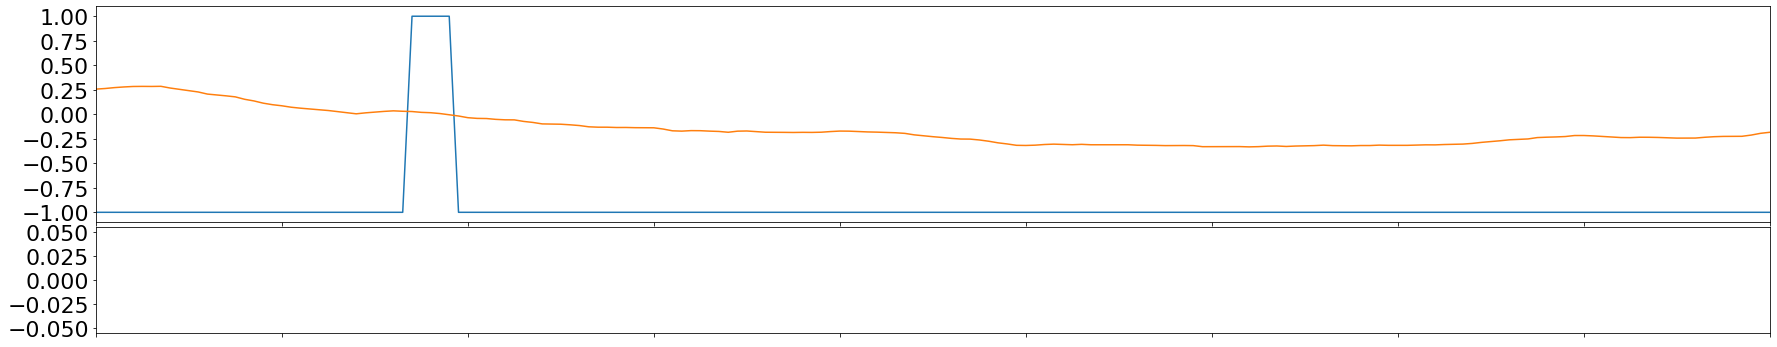

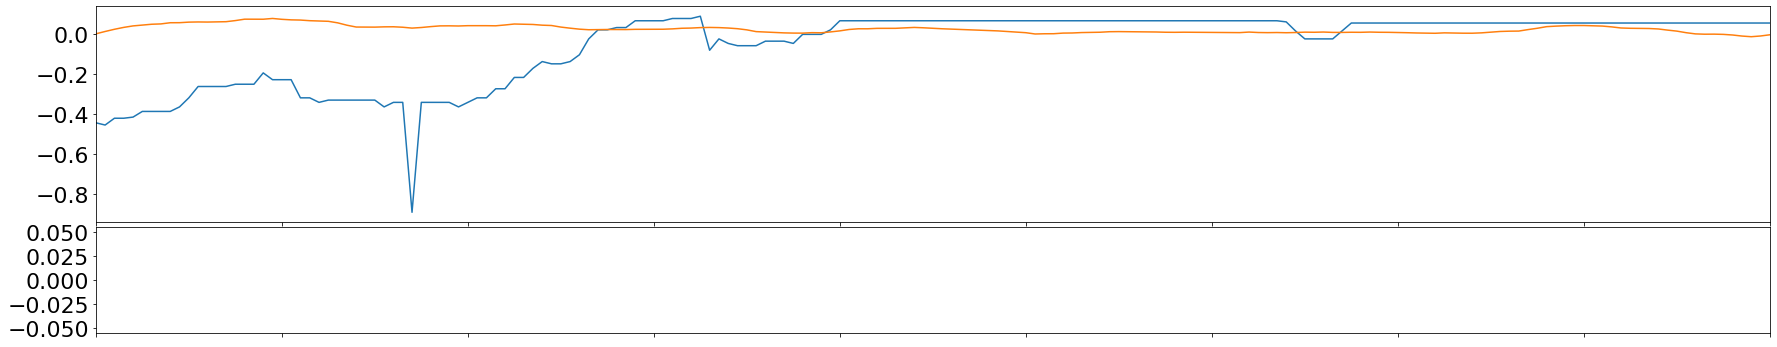

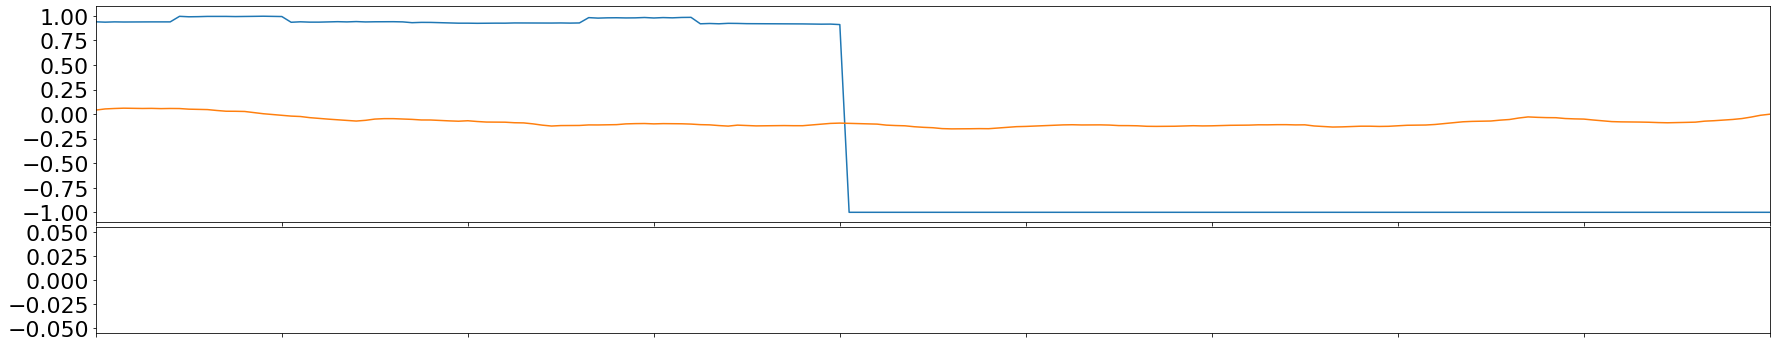

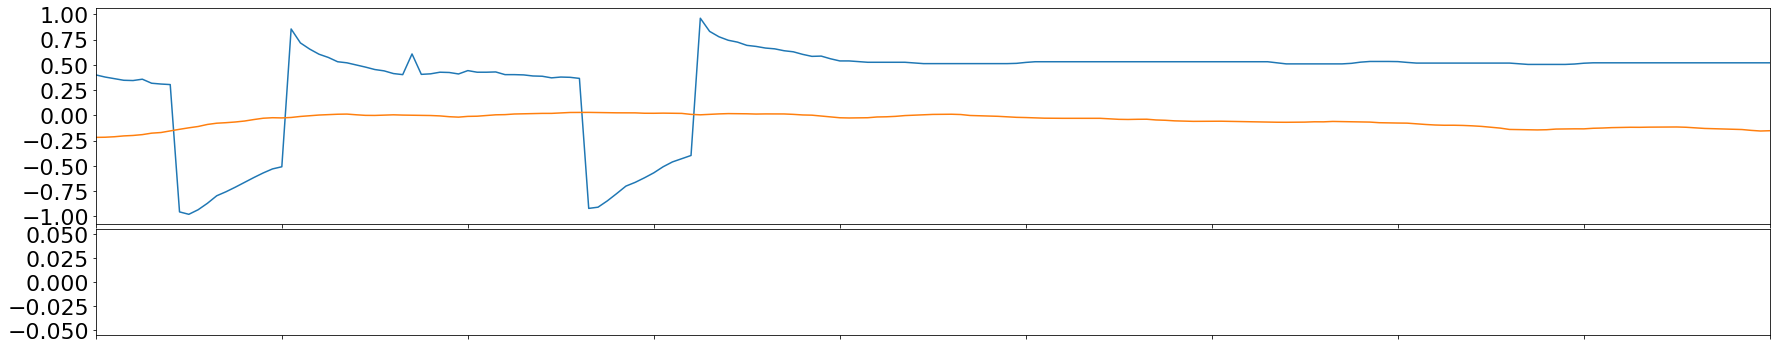

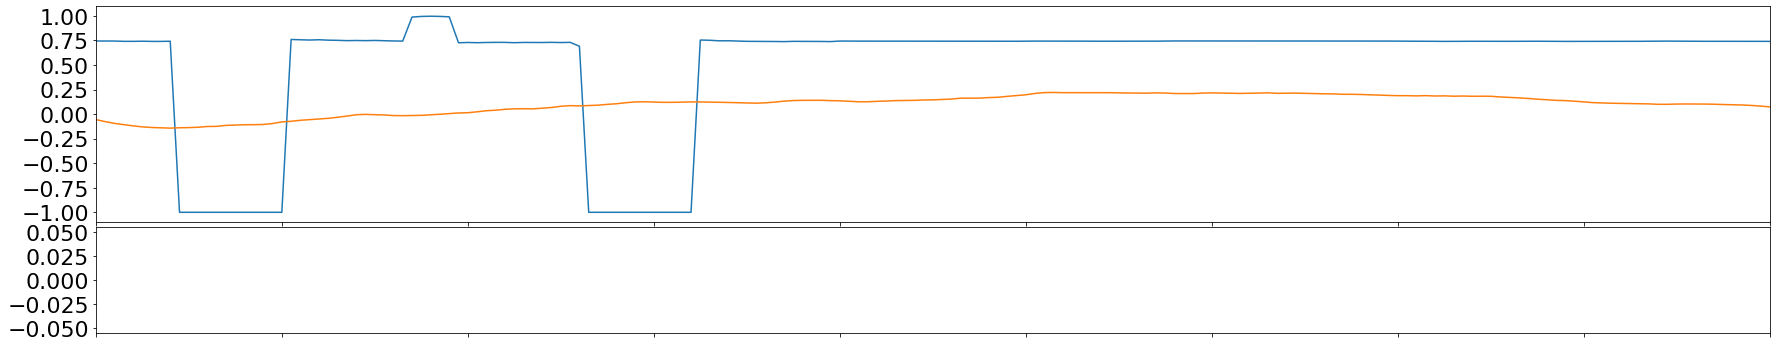

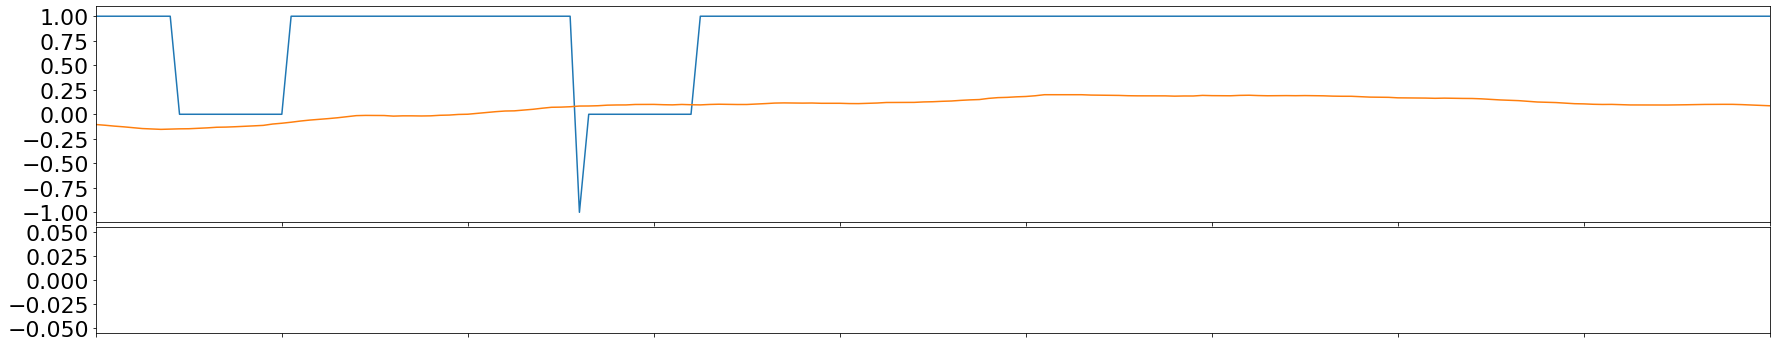

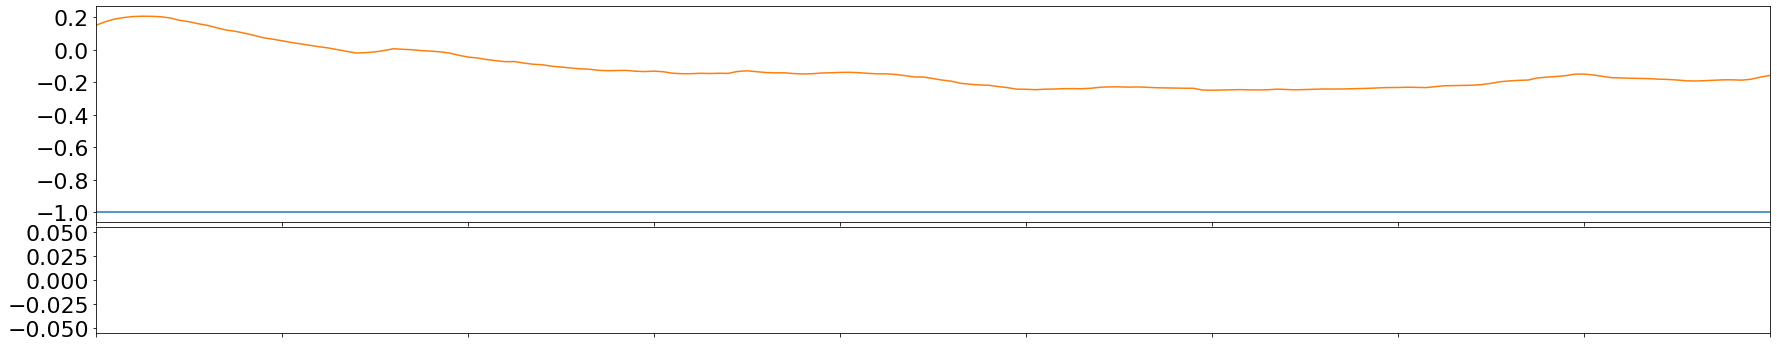

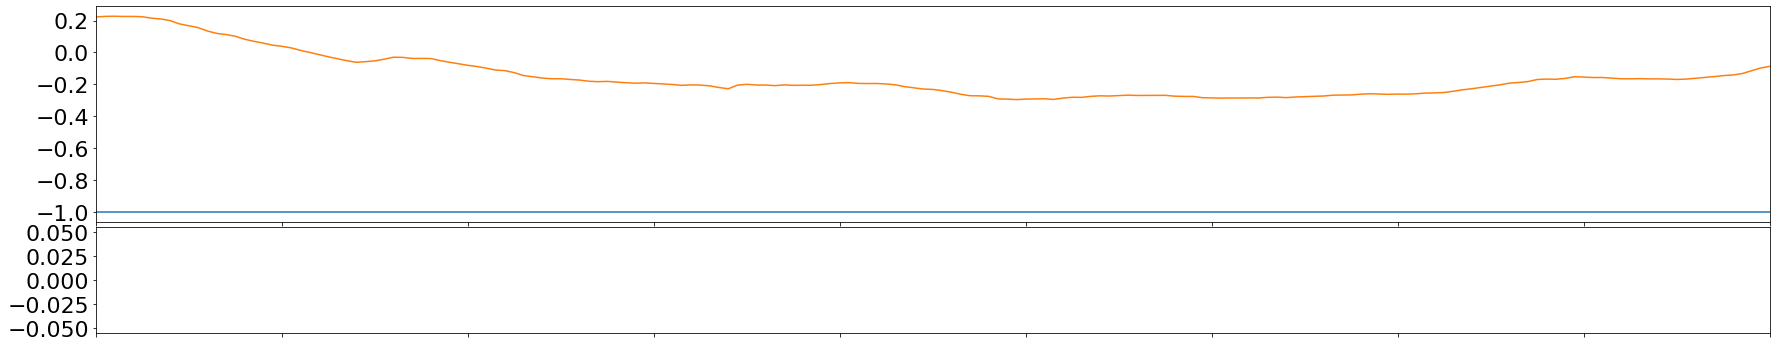

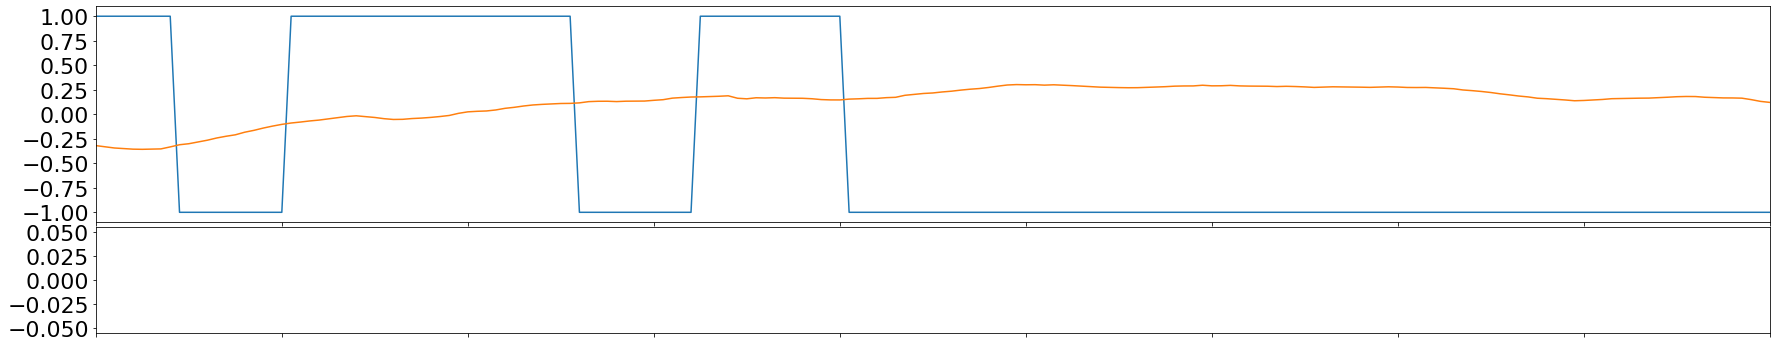

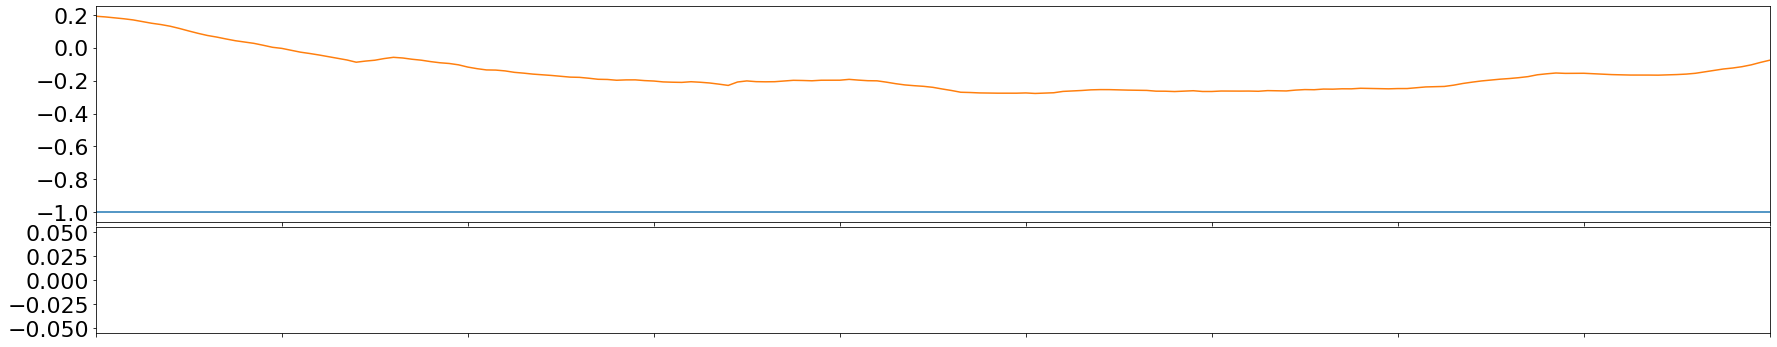

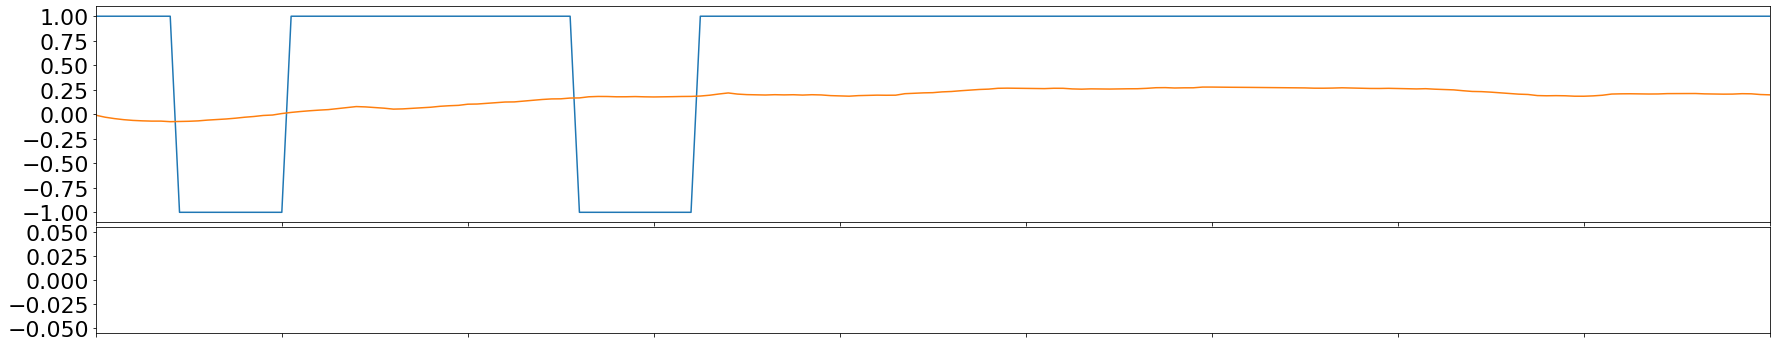

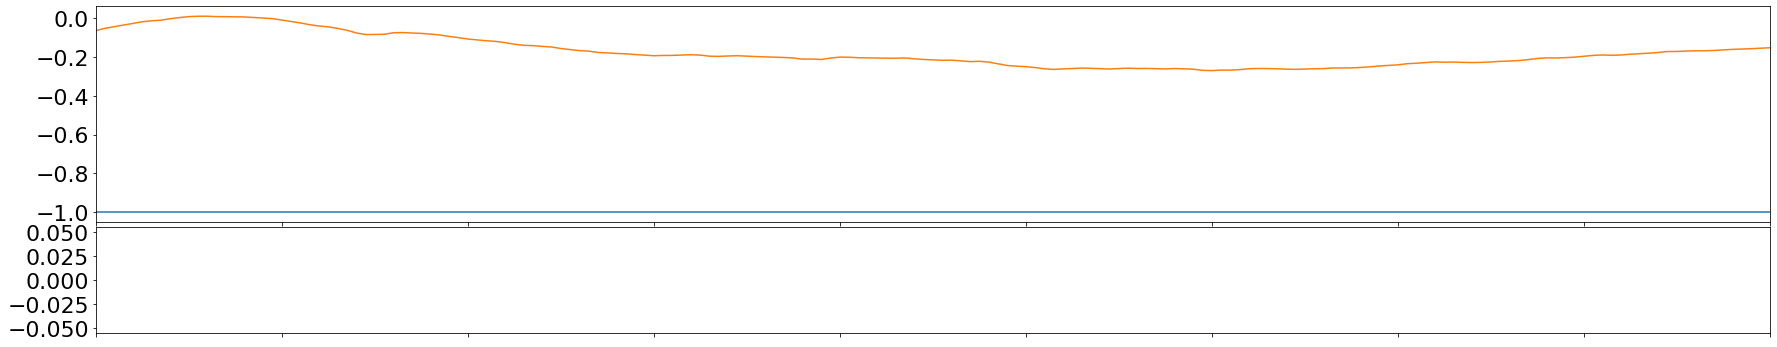

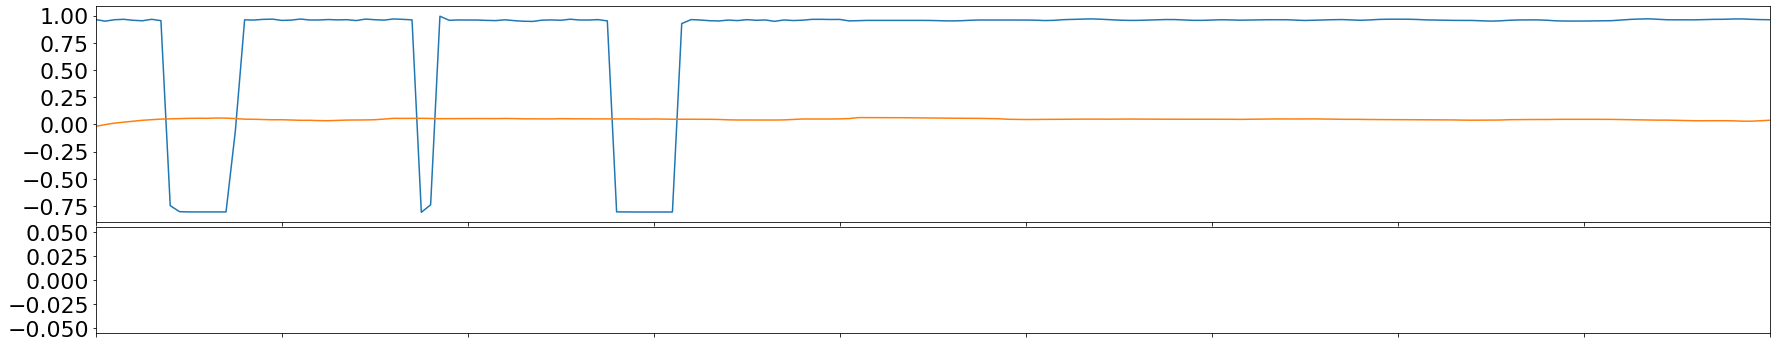

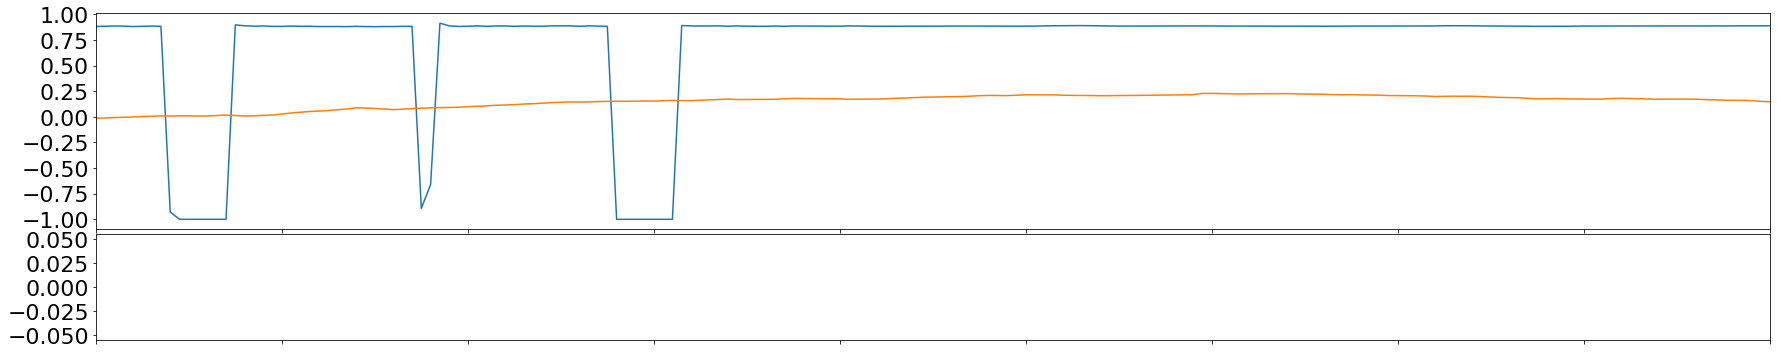

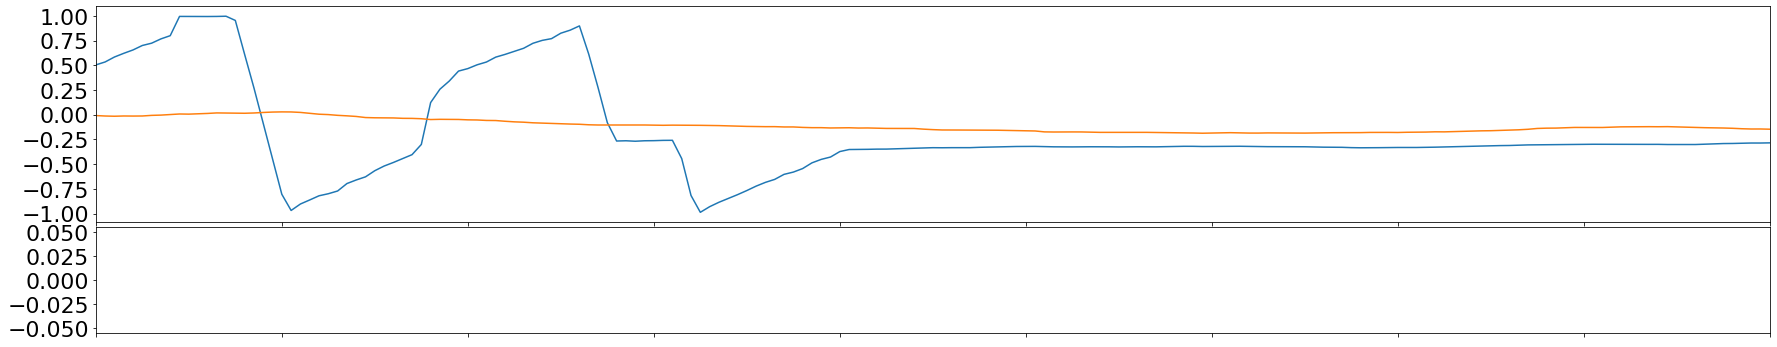

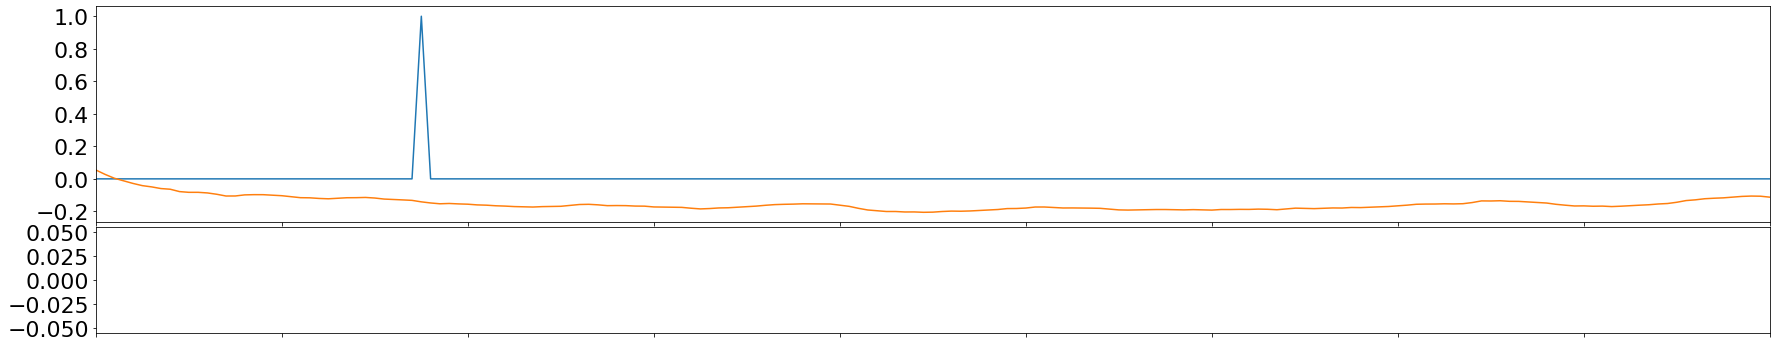

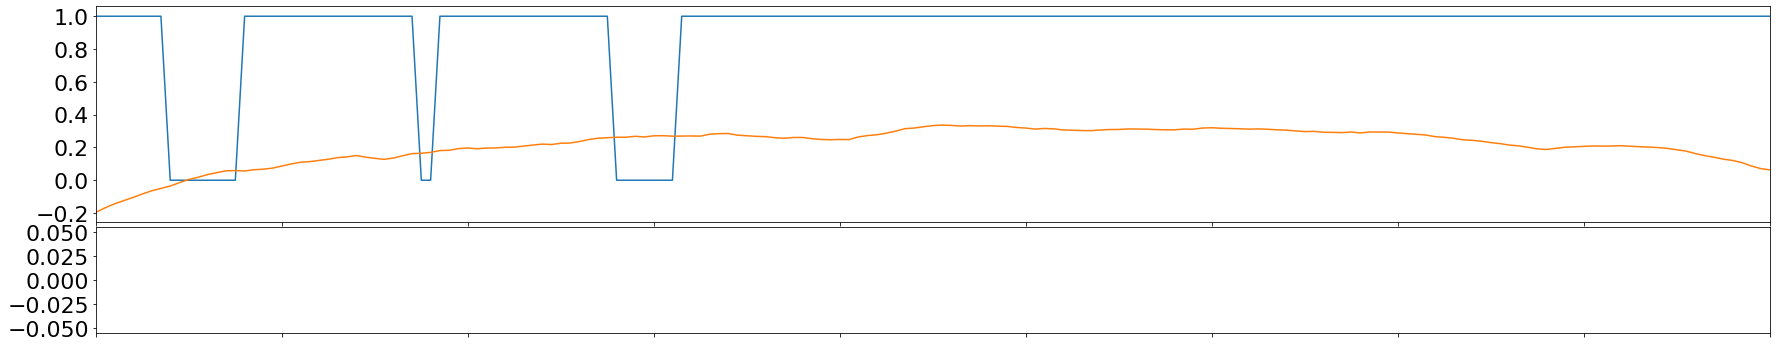

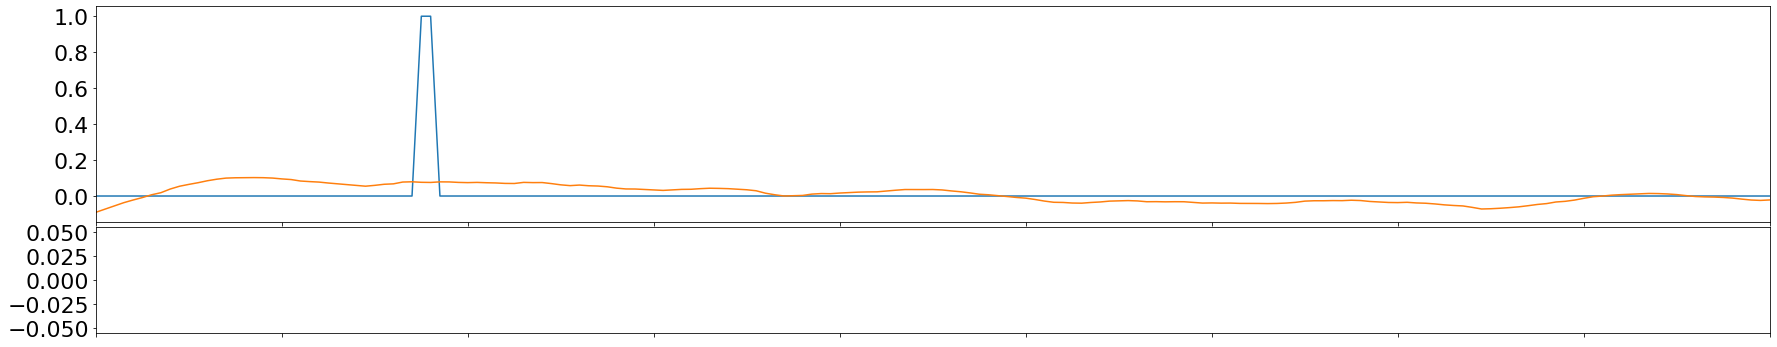

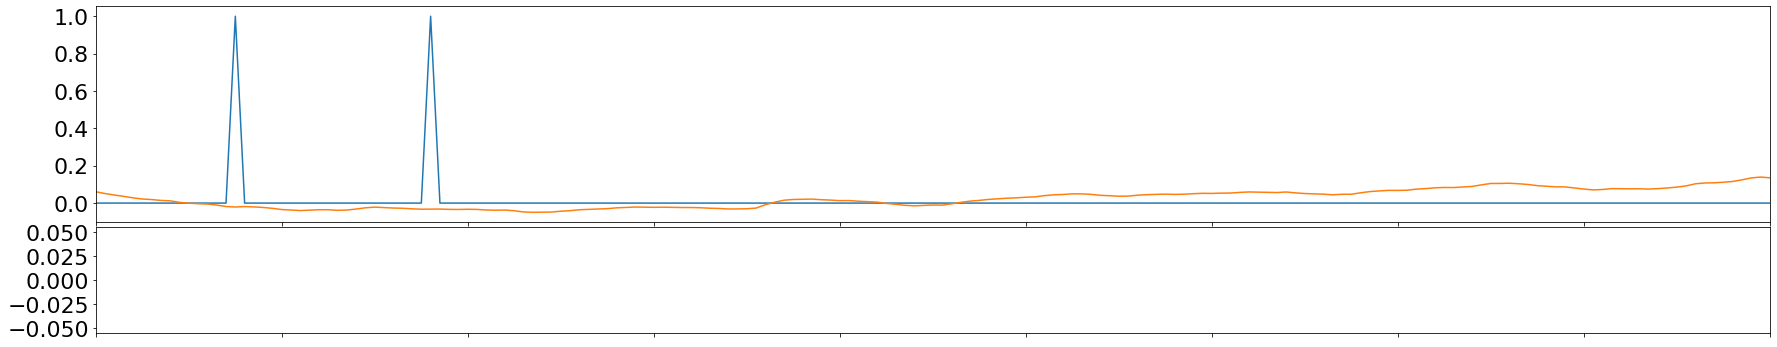

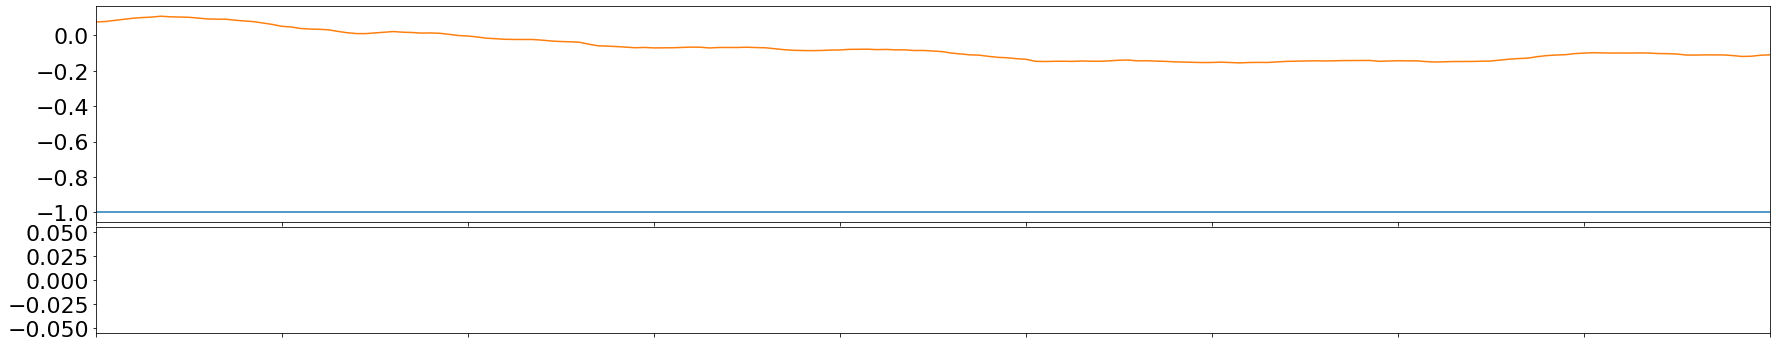

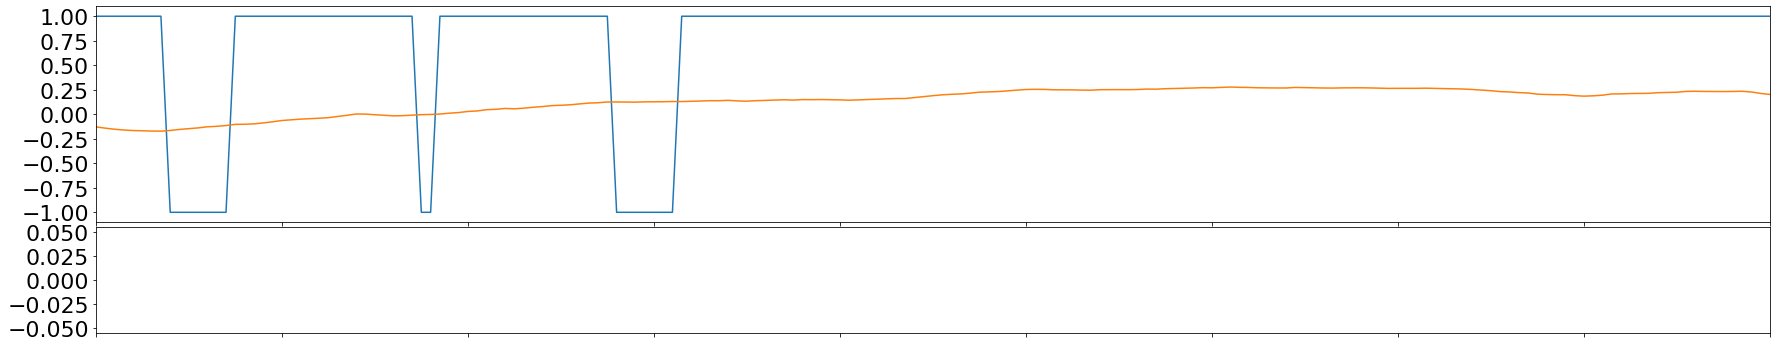

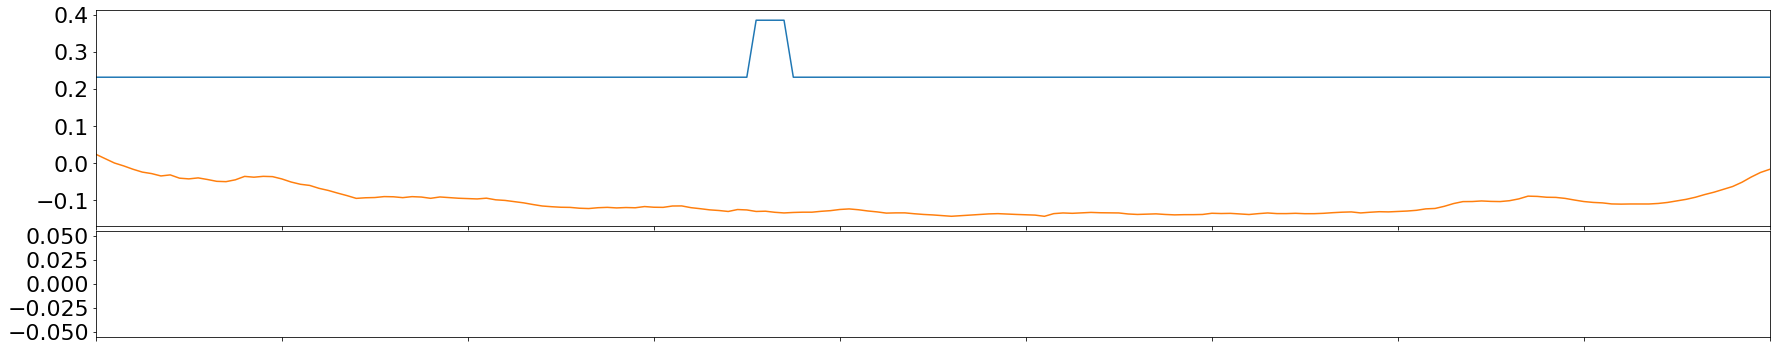

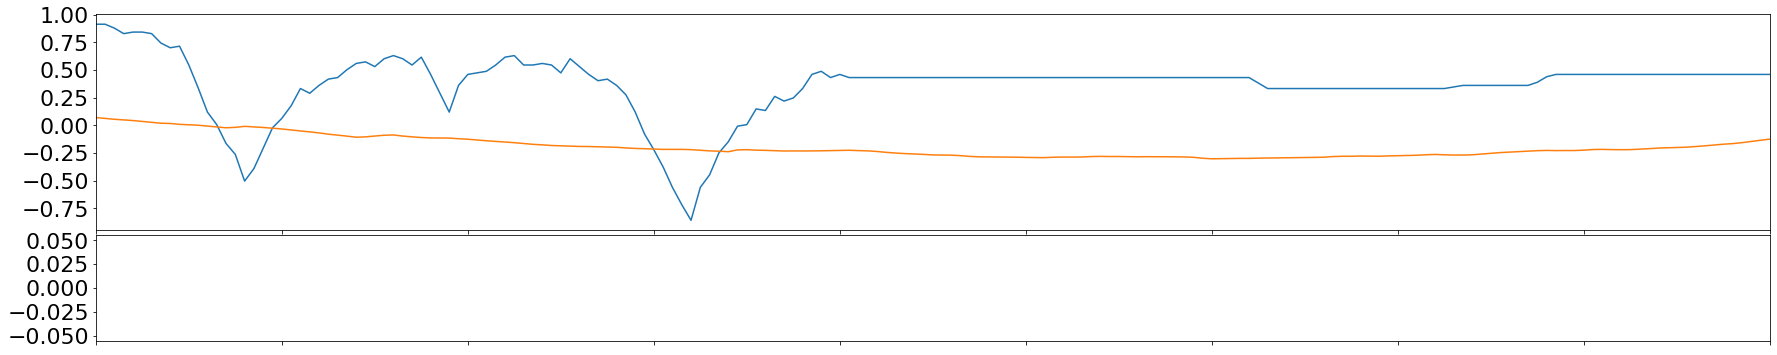

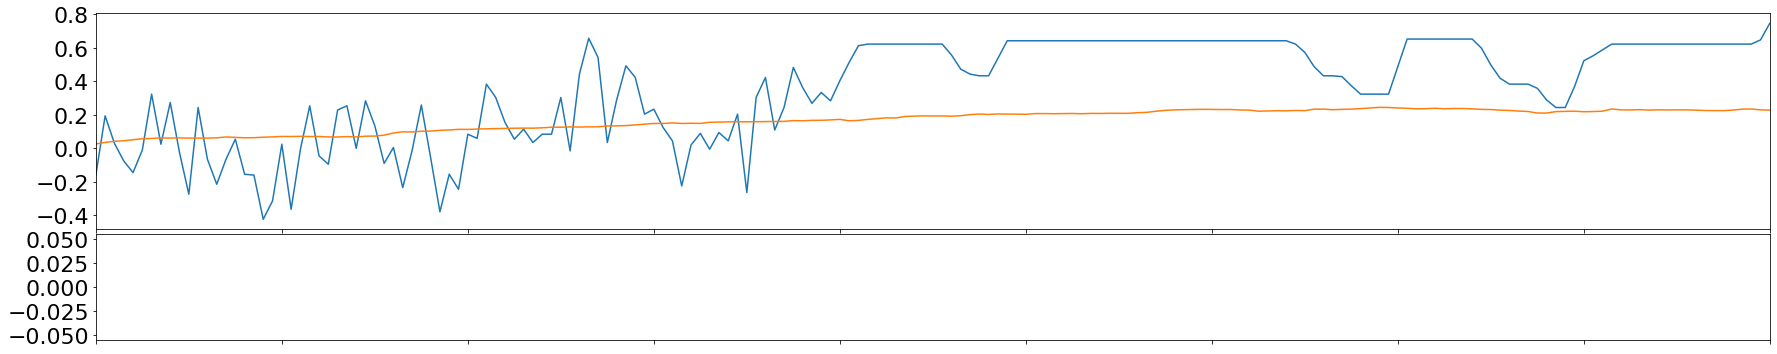

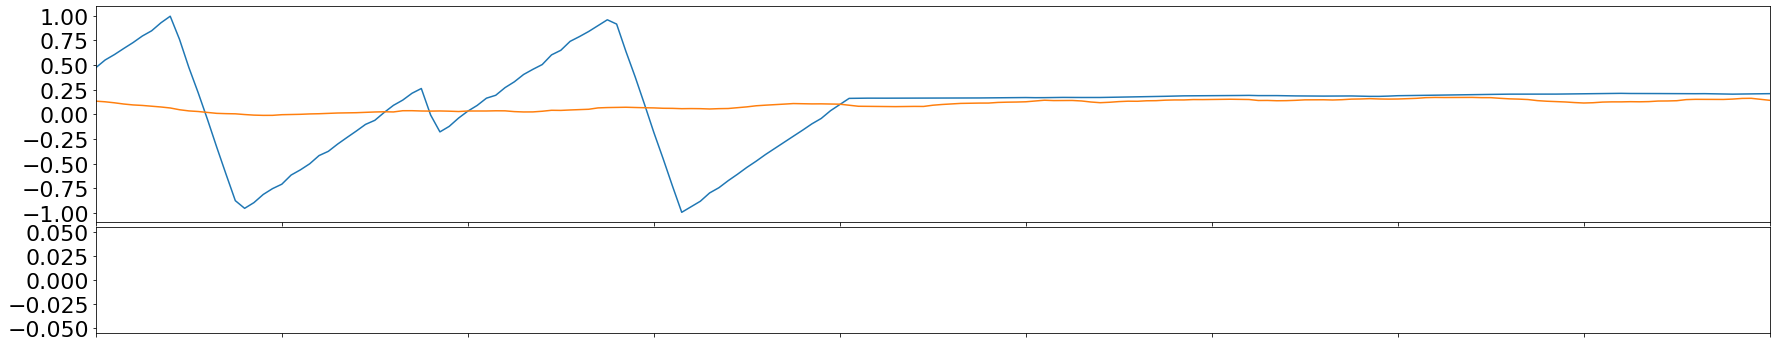

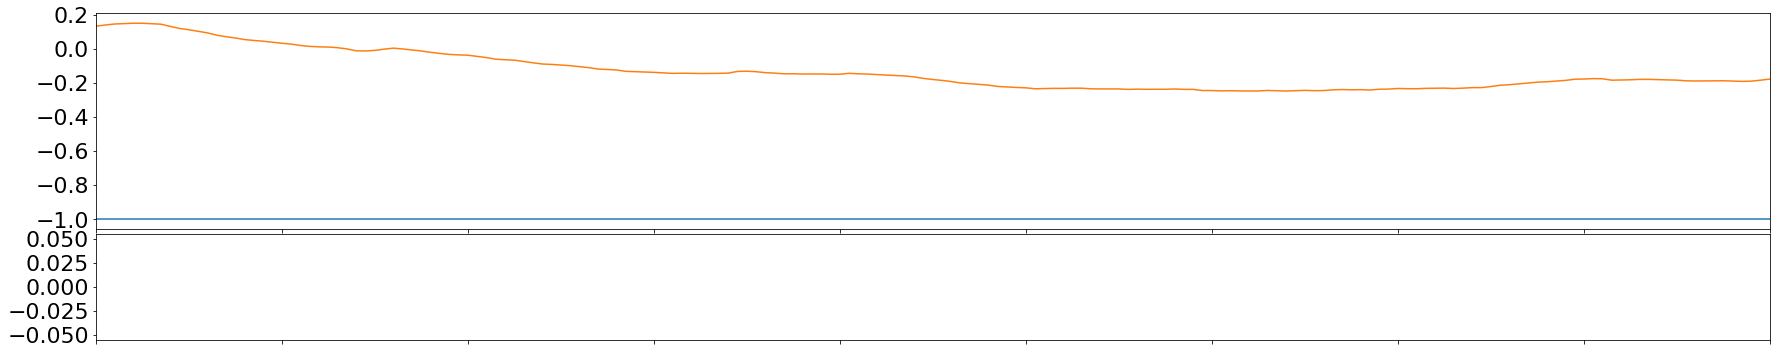

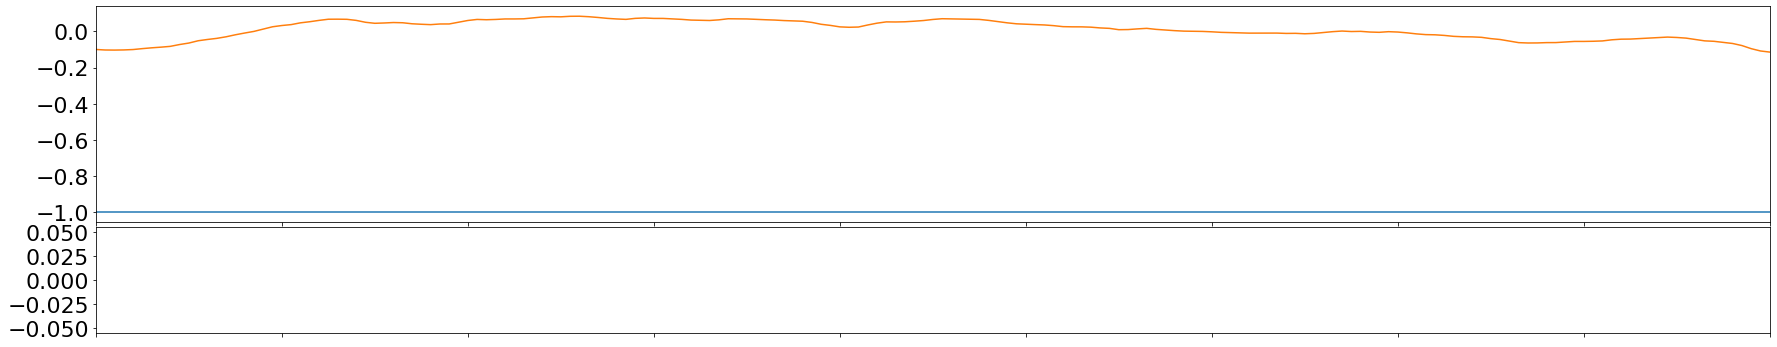

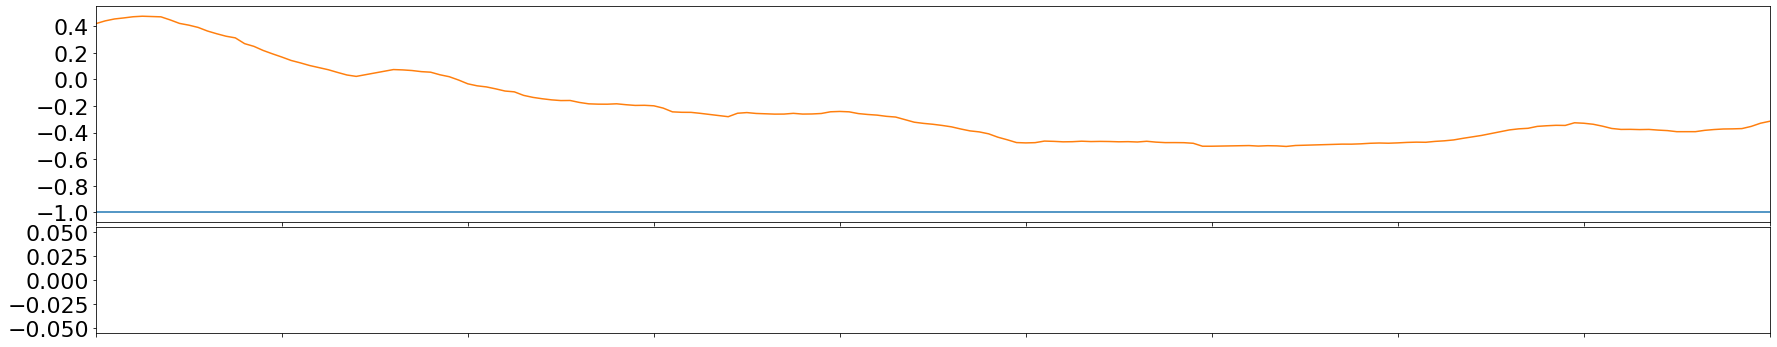

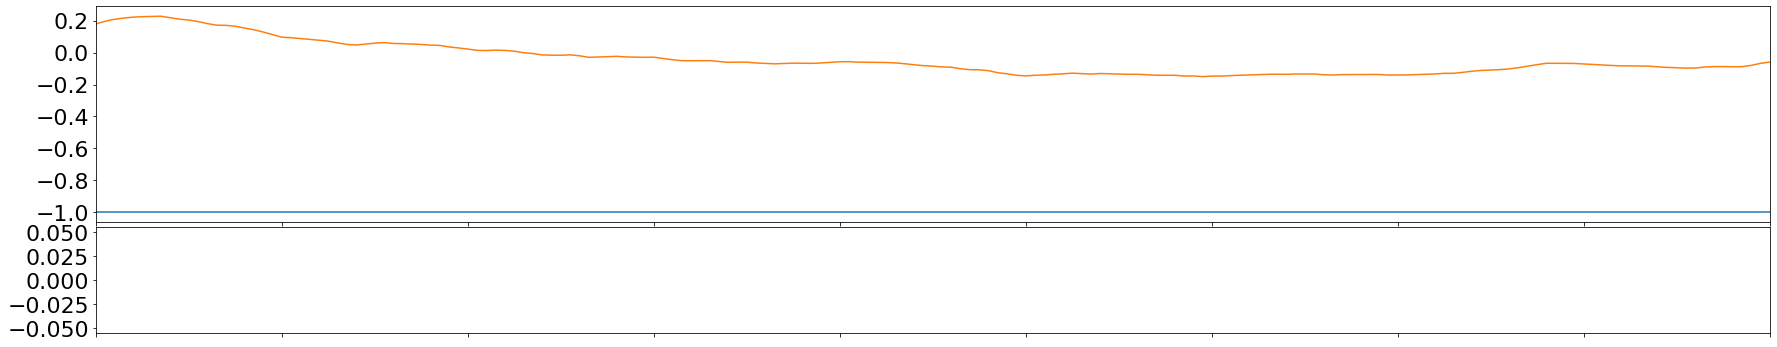

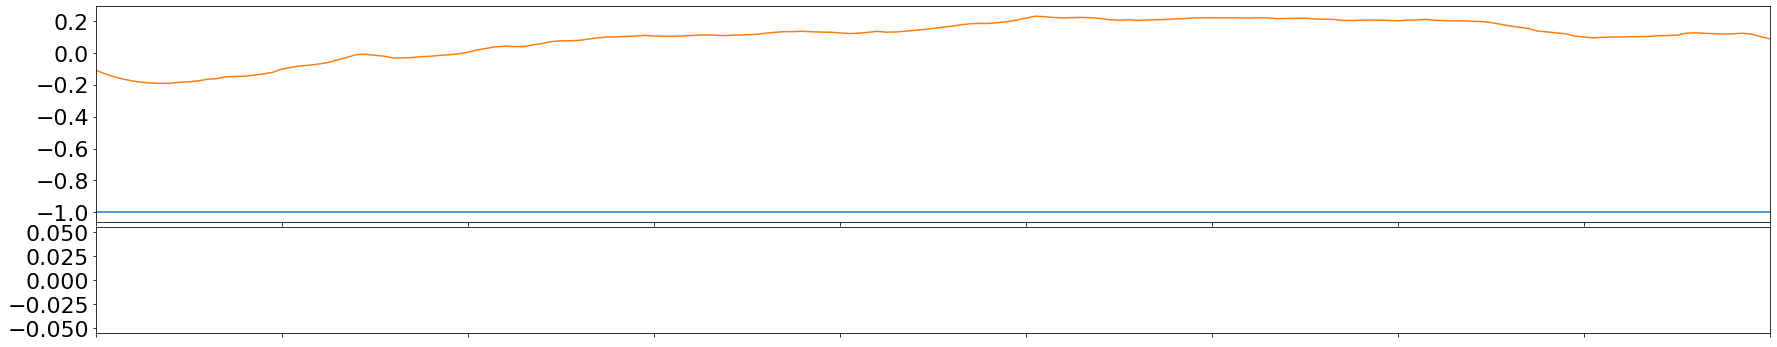

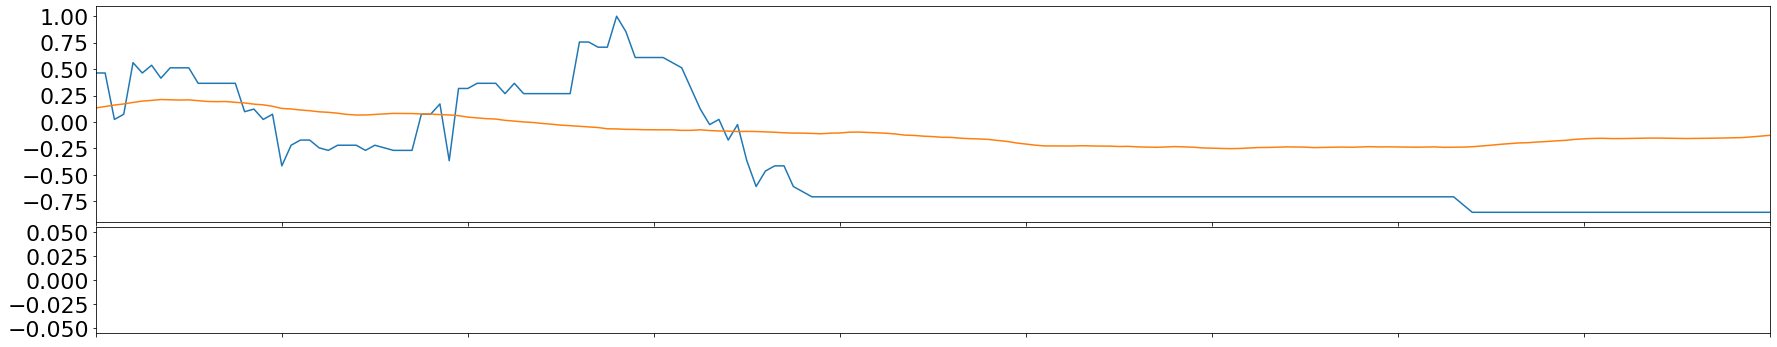

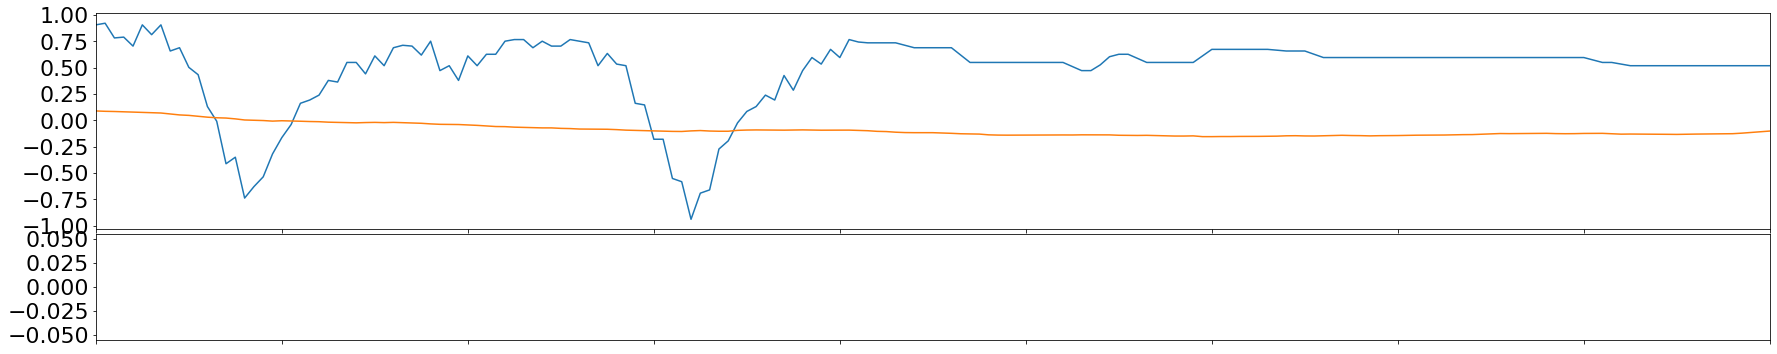

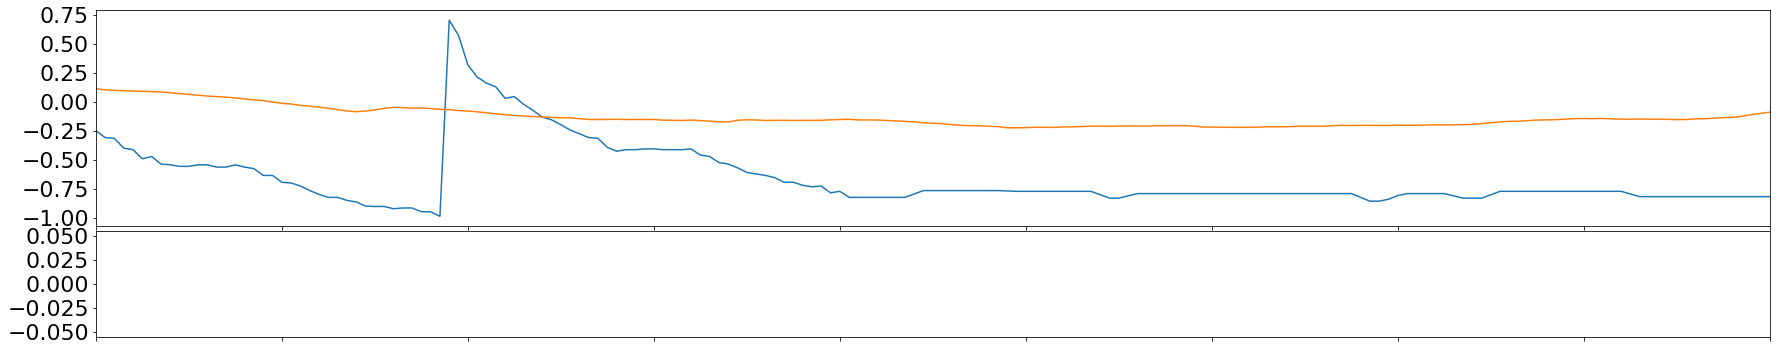

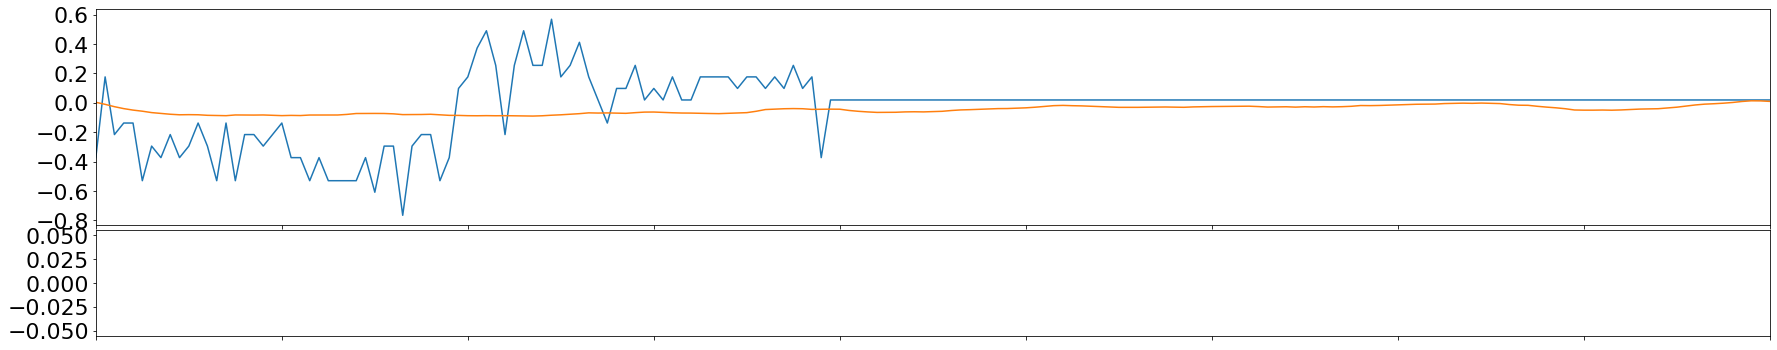

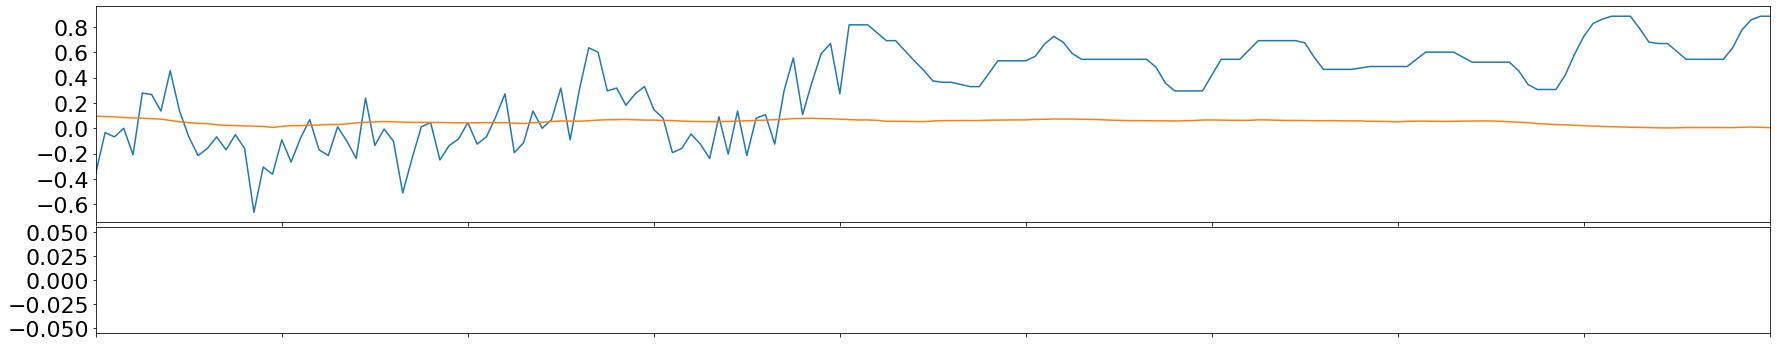

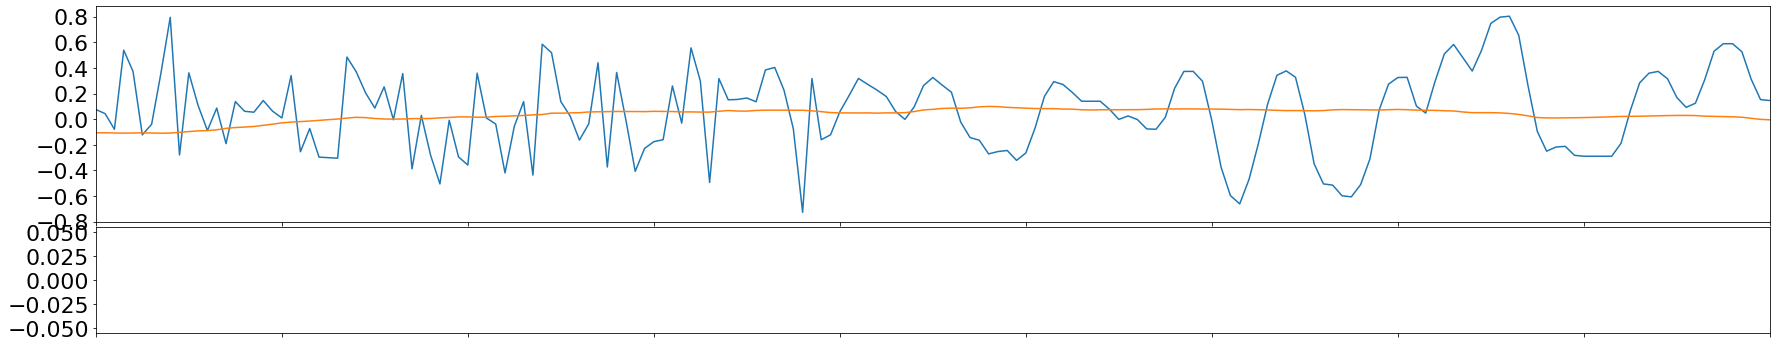

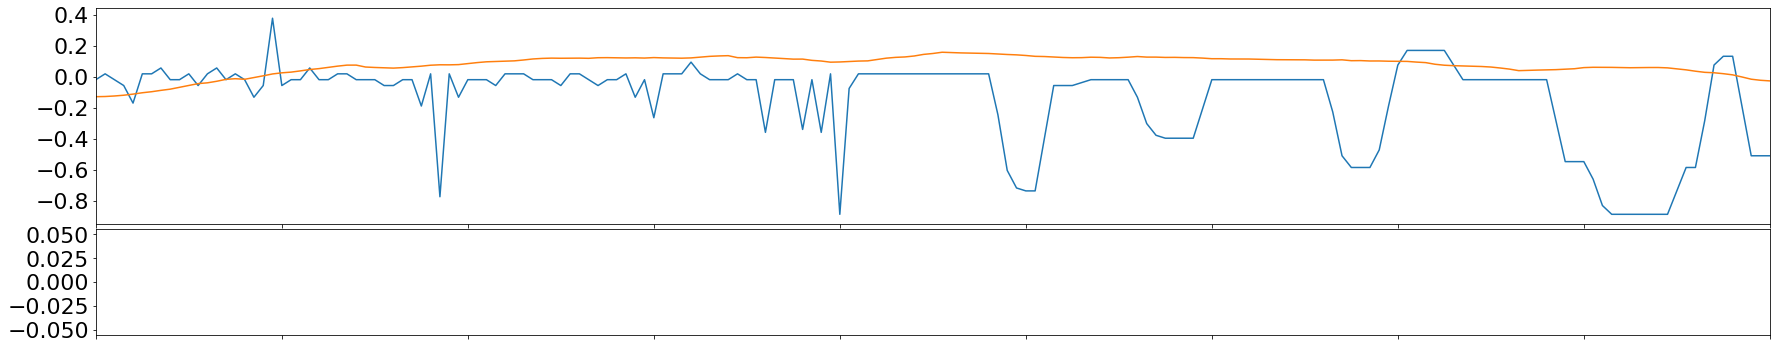

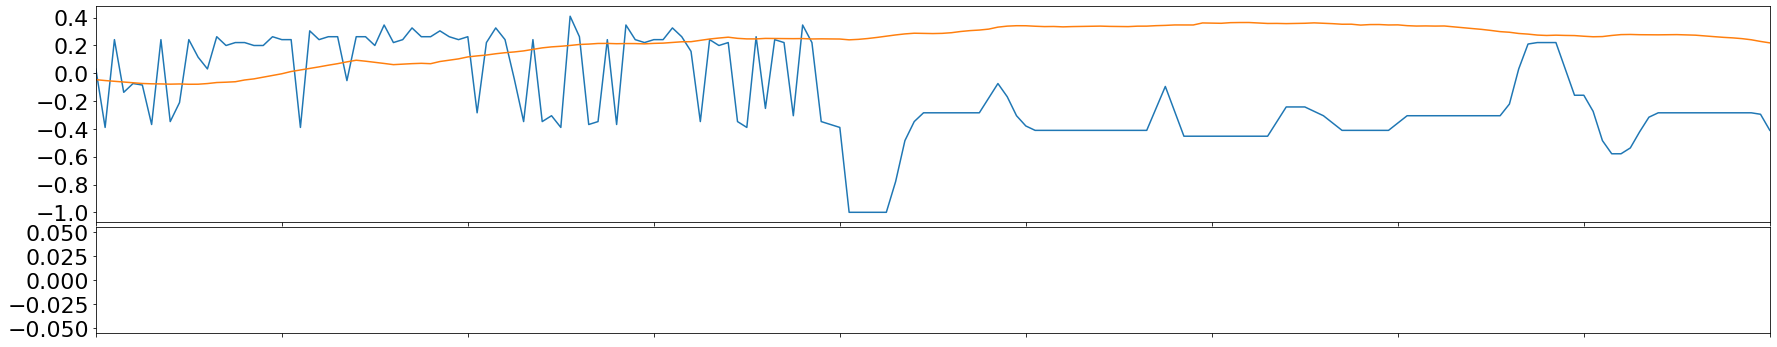

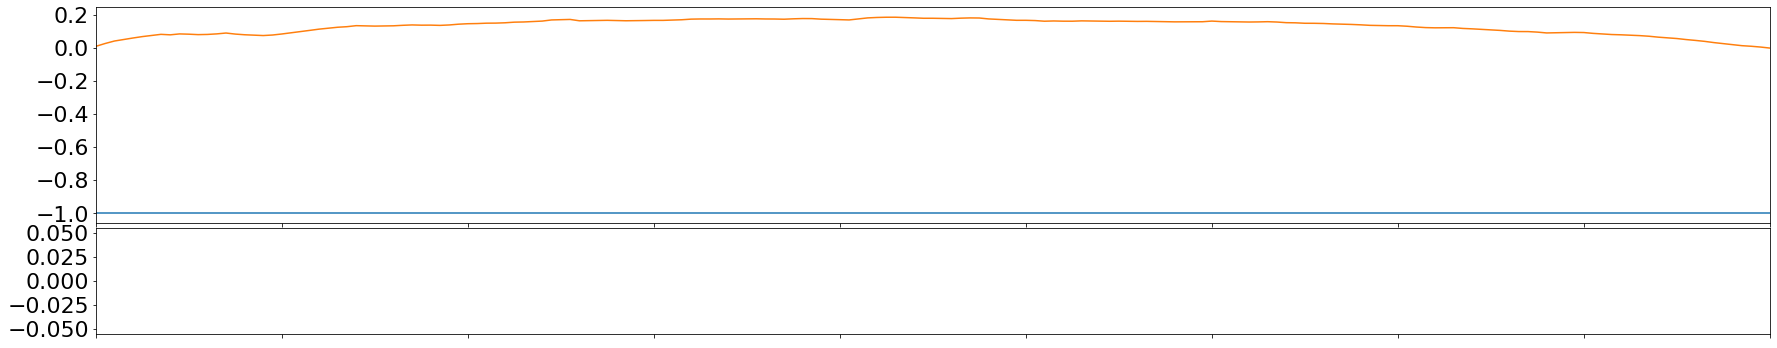

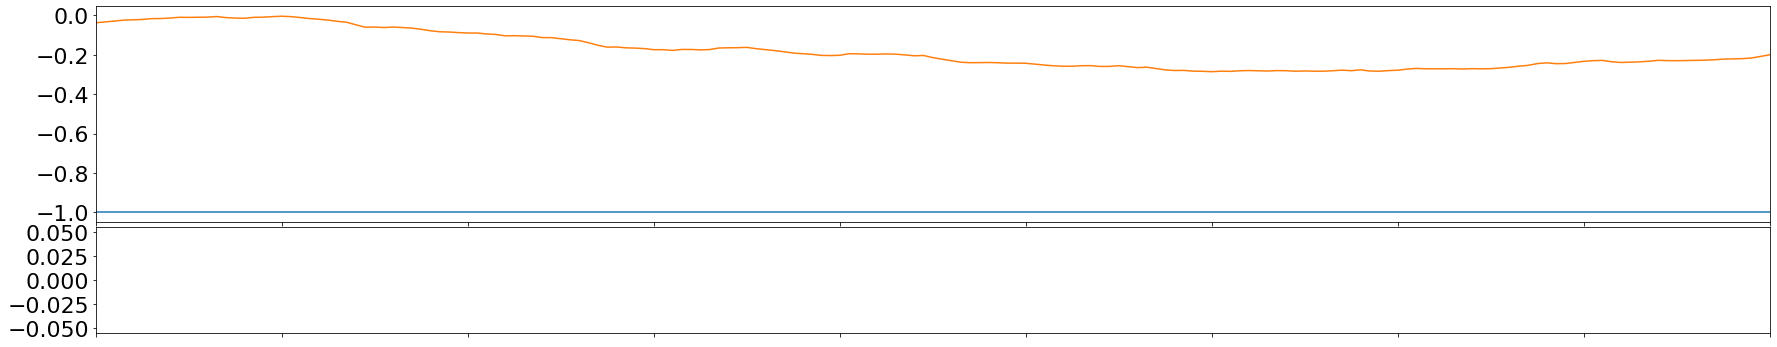

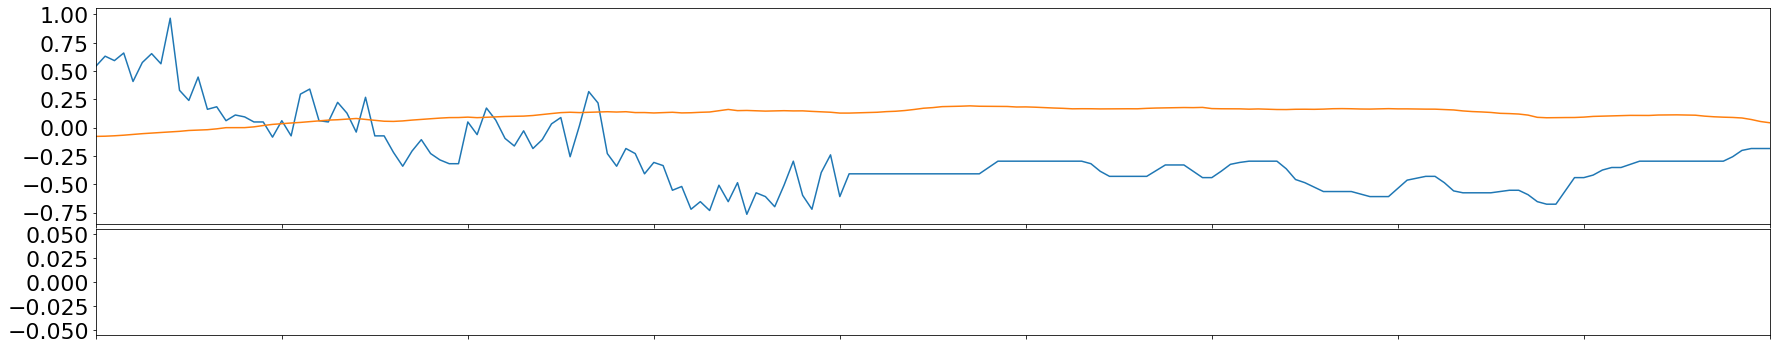

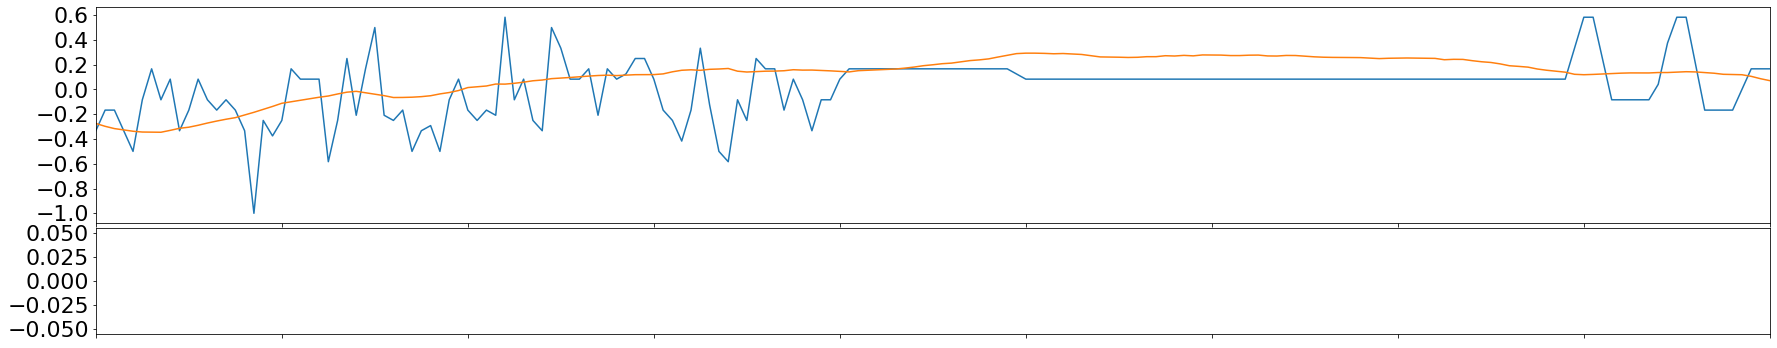

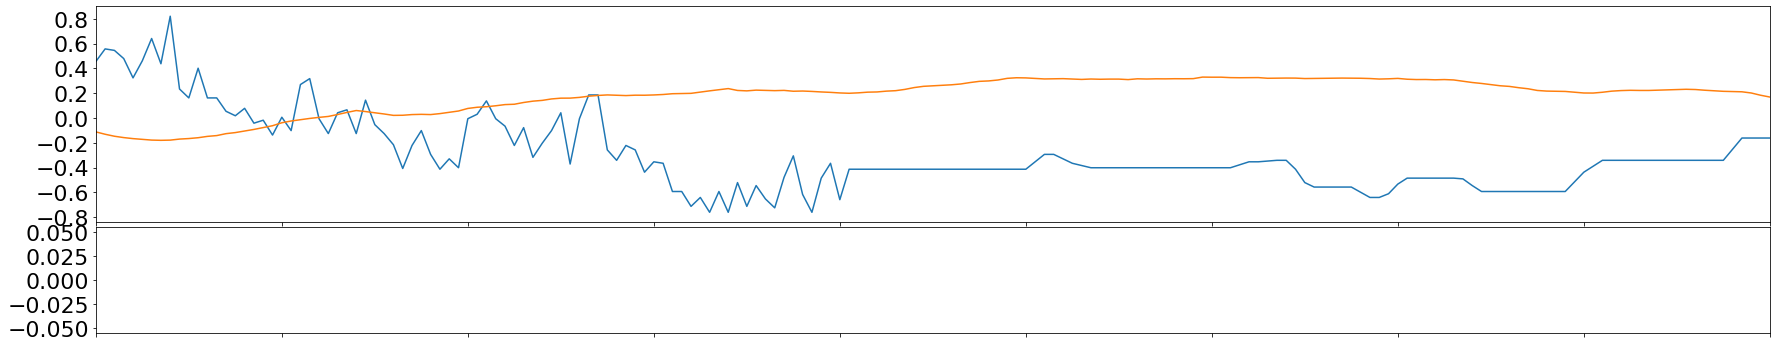

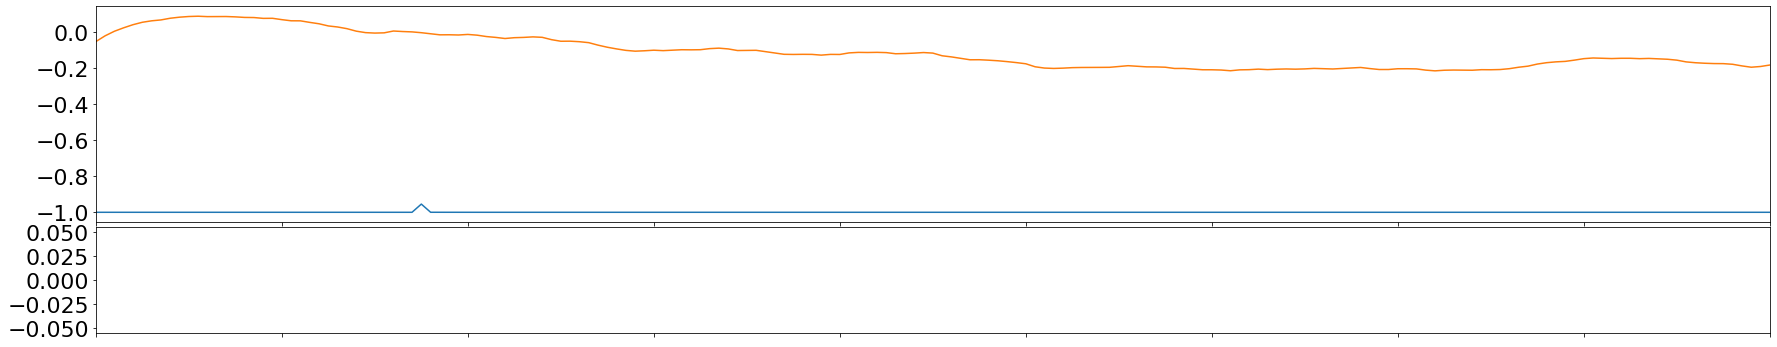

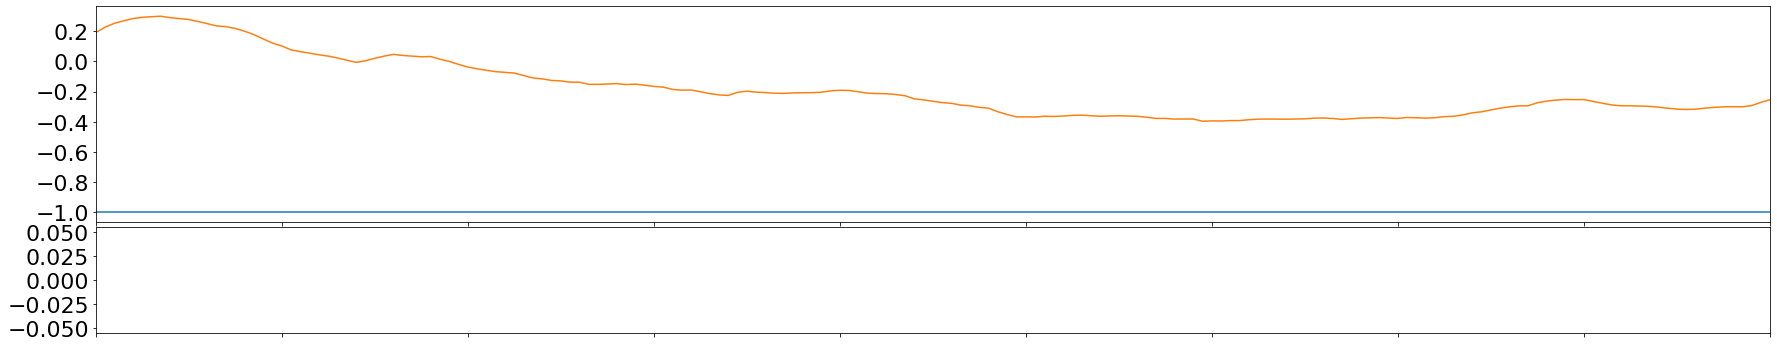

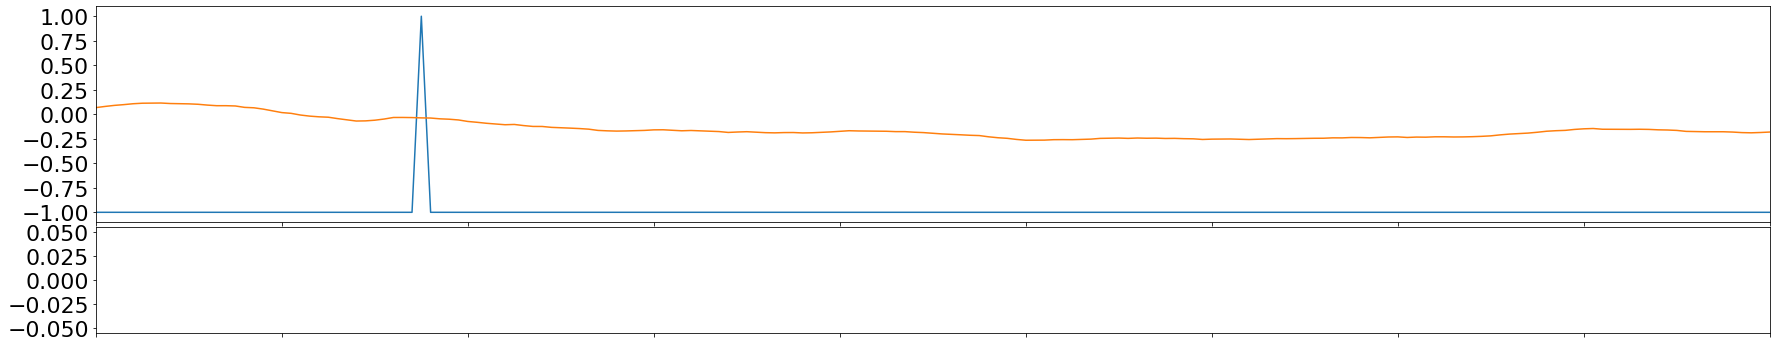

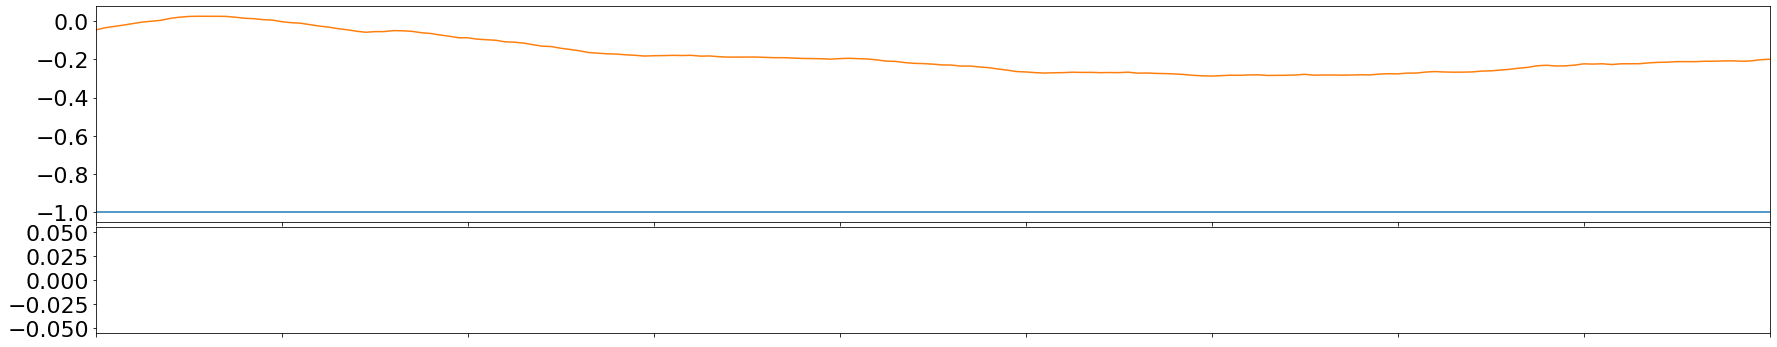

In [23]:
# visualize the error curve
pred_reshaped = np.array(pred).reshape(np.array(true).shape)
for i in range(len(pred_reshaped[0])):
    plot_error([[np.array(true)[:,i], np.array(pred_reshaped)[:,i]], error])

In [24]:
# threshold
thresh = 5

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index_test[i]
    while i < max_start and error[i] > thresh:
        i += 1
    
    end = index_test[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[]

In [25]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])

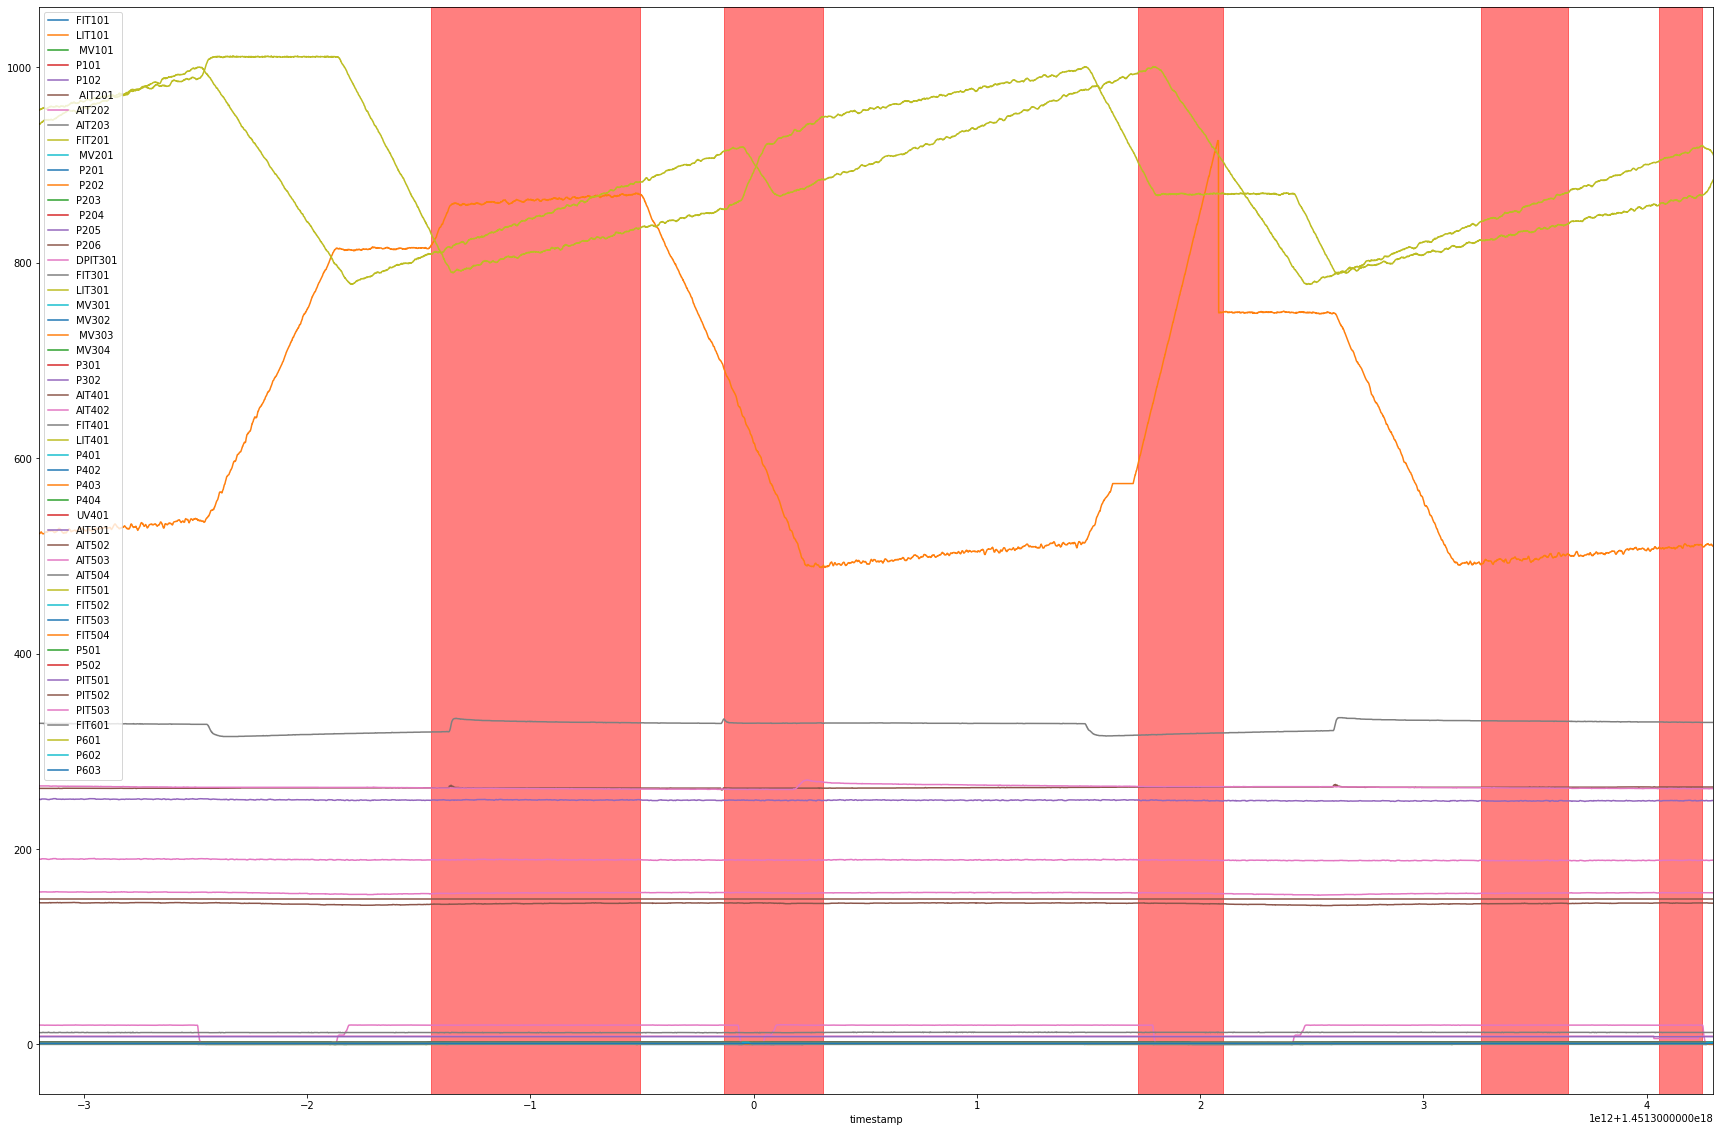

In [26]:
plt.rcParams['figure.figsize'] = [30, 20]
df_test.plot(x="timestamp")

for ind in range(len(known_anomalies)):
    plt.axvspan(known_anomalies["start"][ind], known_anomalies["end"][ind], color='red', alpha=0.5)
for ind in range(len(intervals)):
    plt.axvspan(anomalies["start"][ind], anomalies["end"][ind], color='blue', alpha=0.5)

plt.show()

In [27]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals_window = find_anomalies(error, index_test, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals_window

/home/top/.pyenv/versions/3.7.12/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/home/top/.pyenv/versions/3.7.12/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/home/top/.pyenv/versions/3.7.12/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/home/top/.pyenv/versions/3.7.12/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/home/top/.pyenv/versions/3.7.12/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/home/top/

array([], dtype=float64)

In [28]:
# visualize the result
anomalies_window = pd.DataFrame(intervals_window, columns=['start', 'end', 'score'])

ValueError: Empty data passed with indices specified.

In [ ]:
plt.rcParams['figure.figsize'] = [30, 20]
df_test.plot(x="timestamp")

for ind in range(len(known_anomalies)):
    plt.axvspan(known_anomalies["start"][ind], known_anomalies["end"][ind], color='red', alpha=0.5)
for ind in range(len(intervals_window)):
    plt.axvspan(anomalies_window["start"][ind], anomalies_window["end"][ind], color='blue', alpha=0.5)

plt.show()

In [ ]:
score = 0
overall_count = 0
for ind in range(len(known_anomalies)):
    for i in range(known_anomalies["start"][ind], known_anomalies["end"][ind], 1000000000):
        overall_count += 1
        for j in range(len(anomalies_window)):
            if anomalies_window["start"][j] <= i <= anomalies_window["end"][j]:
                score += 1
                    
print(score, " / ", overall_count)

In [ ]:
step_size